In [1]:
%load_ext rpy2.ipython
%load_ext autotime
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import sys
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation
from pprint import pprint

R[write to console]: Installing package into ‘/home/stephan/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



Reinstalling childesr version 0.2.1


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/childesr_0.2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 22865 bytes (22 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso

time: 11.1 s (started: 2023-01-24 10:16:38 -08:00)


In [2]:
%%R
# load R dependencies
library('plyr')
library('tidyr')
library('plotROC')
library('pROC')
library('lme4')

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




time: 1.57 s (started: 2023-01-24 10:16:49 -08:00)


In [3]:
sys.path.append('../../')
from src.utils import sample_models_across_time, load_models, hyperparameter_utils, configuration, paths
config = configuration.Config()

time: 306 ms (started: 2023-01-24 10:16:51 -08:00)


In [4]:
%%R
filter_model_subset = function(this_df, model_names_list){
    #return(this_df[this_df$model %in% model_names_list])
    return(subset(this_df, this_df$model %in% model_names_list))
}

sem <- function(x) sd(x)/sqrt(length(x))

time: 7.24 ms (started: 2023-01-24 10:16:51 -08:00)


# Load Scores and move to R

In [35]:
import imp
imp.reload(sample_models_across_time)
imp.reload(load_models)
imp.reload(hyperparameter_utils)
imp.reload(paths)
config = configuration.Config()

time: 9.77 ms (started: 2023-01-24 11:08:05 -08:00)


In [33]:
%pdb

Automatic pdb calling has been turned ON
time: 1.19 ms (started: 2023-01-24 11:07:15 -08:00)


In [36]:
levdist_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('levdist'))
# Remove 0.5 and 4.0 because they are sparse.
levdist_scores_across_time = levdist_scores_across_time[~levdist_scores_across_time.age.isin({0.5, 4.0})]
levdist_scores_across_time['likelihood_type'] = 'Levenshtein Distance'

Generating ngram model args
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_0_1/levdist_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_20_1/levdist_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_[20, 0]_1/levdist_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxGPT-2_Providence_all_0_1/levdist_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxGPT-2_Providence_all_20_1/levdist_run_models_across_time_*.pkl
Searching /home/stephan/note

In [39]:
np.unique(levdist_scores_across_time.model)

array(['eval_Providence-Age_old_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_BERT_Providence_all_0',
       'eval_Providence_all_no_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_0_0',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_0_1',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_[20, 0]_0',
       'eval_Providence_all_no_tags_data_unigram_Providence_all_0',
       'eval_Providence_all_with_tags_BERT_Providence_all_0',
       'eval_Providenc

time: 769 ms (started: 2023-01-24 11:08:30 -08:00)


In [40]:
wfst_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('wfst'))
# Remove 0.5 and 4.0 because they are sparse.
wfst_scores_across_time = wfst_scores_across_time[~wfst_scores_across_time.age.isin({0.5, 4.0})]
wfst_scores_across_time['likelihood_type'] = 'WFST'

Generating ngram model args
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_0_1/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_20_1/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxGPT-2_Providence_all_[20, 0]_1/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxGPT-2_Providence_all_0_1/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxGPT-2_Providence_all_20_1/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-dir

In [41]:
np.unique(wfst_scores_across_time.model)

array(['eval_Providence-Age_old_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_BERT_Providence_all_0',
       'eval_Providence_all_no_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_0_0',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_0_1',
       'eval_Providence_all_no_tags_GPT-2_Providence_all_[20, 0]_0',
       'eval_Providence_all_no_tags_data_unigram_Providence_all_0',
       'eval_Providence_all_with_tags_BERT_Providence_all_0',
       'eval_Providenc

time: 724 ms (started: 2023-01-24 11:08:44 -08:00)


In [42]:
scores_across_time = pd.concat([levdist_scores_across_time, wfst_scores_across_time])

time: 1.32 s (started: 2023-01-24 11:08:47 -08:00)


In [137]:
# this takes forever -- moving things into R is expensive
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_probability','posterior_entropy','prior_probability','prior_entropy',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance','likelihood_type','prior_rank','posterior_rank']]
%R -i scores_across_time_short 

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


time: 1min 51s (started: 2023-01-24 11:50:39 -08:00)


In [138]:
%%R
levels(factor(scores_across_time_short$model))

 [1] "eval_adult-written_all_no_tags_BERT_Providence_all_0"          
 [2] "eval_adult-written_all_no_tags_BERT_Providence_all_20"         
 [3] "eval_no-split_no-dataset_no_tags_flat_unigram_Providence_all_0"
 [4] "eval_Providence_all_no_tags_BERT_Providence_all_0"             
 [5] "eval_Providence_all_no_tags_BERT_Providence_all_20"            
 [6] "eval_Providence_all_no_tags_data_unigram_Providence_all_0"     
 [7] "eval_Providence_all_no_tags_GPT-2_Providence_all_[20, 0]_0"    
 [8] "eval_Providence_all_no_tags_GPT-2_Providence_all_0_0"          
 [9] "eval_Providence_all_no_tags_GPT-2_Providence_all_0_1"          
[10] "eval_Providence_all_with_tags_BERT_Providence_all_[20, 0]"     
[11] "eval_Providence_all_with_tags_BERT_Providence_all_0"           
[12] "eval_Providence_all_with_tags_BERT_Providence_all_20"          
[13] "eval_Providence_all_with_tags_GPT-2_Providence_all_[20, 0]_0"  
[14] "eval_Providence_all_with_tags_GPT-2_Providence_all_0_0"        
[15] "eval_Providenc

In [139]:
%%R
model_remapper = list()
model_remapper[["eval_adult-written_all_no_tags_BERT_Providence_all_[20, 0]"]] = 'BERT+LeftContext'    
model_remapper[["eval_adult-written_all_no_tags_BERT_Providence_all_0"]] = 'BERT+OneUtt'  
model_remapper[["eval_adult-written_all_no_tags_BERT_Providence_all_20"]]= 'BERT+Context'          
model_remapper[["eval_no-split_no-dataset_no_tags_flat_unigram_Providence_all_0"]] = 'UniformPrior' 
model_remapper[["eval_Providence_all_no_tags_BERT_Providence_all_[20, 0]"]] = 'CDL+LeftContext'      
model_remapper[["eval_Providence_all_no_tags_BERT_Providence_all_0"]] = 'CDL+OneUtt'              
model_remapper[["eval_Providence_all_no_tags_BERT_Providence_all_20"]] = 'CDL+Context'             
model_remapper[["eval_Providence_all_no_tags_data_unigram_Providence_all_0"]] = 'CHILDES 1gram'  
model_remapper[["eval_Providence_all_no_tags_GPT-2_Providence_all_[20, 0]_0"]] = 'GPT-2+LeftContext'   
model_remapper[["eval_Providence_all_no_tags_GPT-2_Providence_all_[20, 0]_1"]]  =  'GPT-2+LeftContext+Bidirectional' 
model_remapper[["eval_Providence_all_no_tags_GPT-2_Providence_all_0_0"]] = 'GPT-2+OneUtt'                   
model_remapper[["eval_Providence_all_no_tags_GPT-2_Providence_all_0_1"]] = 'GPT-2+OneUtt+Bidirectional'          
model_remapper[["eval_Providence_all_with_tags_BERT_Providence_all_[20, 0]"]] =  'CDL+LeftContext+Tags'   
model_remapper[["eval_Providence_all_with_tags_BERT_Providence_all_0"]] = 'CDL+OneUtt+Tags'           
model_remapper[["eval_Providence_all_with_tags_BERT_Providence_all_20"]]  = 'CDL+Context+Tags'          
model_remapper[["eval_Providence_all_with_tags_GPT-2_Providence_all_[20, 0]_0"]] = 'GPT-2+LeftContext+Tags'           
model_remapper[["eval_Providence_all_with_tags_GPT-2_Providence_all_[20, 0]_1"]] = 'GPT-2+LeftContext+Bidirectional+Tags'  
model_remapper[["eval_Providence_all_with_tags_GPT-2_Providence_all_0_0"]] = 'GPT-2+OneUtt+Tags'
model_remapper[["eval_Providence_all_with_tags_GPT-2_Providence_all_0_1"]] = 'GPT-2+Bidirectional+Tags'        
model_remapper[["eval_Providence_all_with_tags_ngram_Providence_all_3_0"]] = 'CHILDES 3gram'        
model_remapper[["eval_Providence_all_with_tags_ngram_Providence_all_3_1"]] = 'CHILDES 3gram+OneUtt'         
model_remapper[["eval_Providence-Age_old_no_tags_BERT_Providence_all_[20, 0]"]] = 'CDL+Older+LeftContext'
model_remapper[["eval_Providence-Age_old_no_tags_BERT_Providence_all_0"]]  = 'CDL+Older+OneUtt'         
model_remapper[["eval_Providence-Age_old_no_tags_BERT_Providence_all_20"]]  = 'CDL+Older+Context'        
model_remapper[["eval_Providence-Age_old_with_tags_BERT_Providence_all_[20, 0]"]]  = 'CDL+Older+LeftContext+Tags' 
model_remapper[["eval_Providence-Age_old_with_tags_BERT_Providence_all_0"]] = 'CDL+Older+OneUtt+Tags'     
model_remapper[["eval_Providence-Age_old_with_tags_BERT_Providence_all_20"]] = 'CDL+Older+Context+Tags'      
model_remapper[["eval_Providence-Age_young_no_tags_BERT_Providence_all_[20, 0]"]] = 'CDL+Younger+LeftContext'  
model_remapper[["eval_Providence-Age_young_no_tags_BERT_Providence_all_0"]] = 'CDL+Younger+OneUtt'                   
model_remapper[["eval_Providence-Age_young_no_tags_BERT_Providence_all_20"]] = 'CDL+Younger+Context'       
model_remapper[["eval_Providence-Age_young_with_tags_BERT_Providence_all_[20, 0]"]] = 'CDL+Younger+LeftContext+Tags'
model_remapper[["eval_Providence-Age_young_with_tags_BERT_Providence_all_0"]]  = 'CDL+Younger+OneUtt+Tags'    
model_remapper[["eval_Providence-Age_young_with_tags_BERT_Providence_all_20"]]  = 'CDL+Younger+Context+Tags'    
model_remapper[["eval_Switchboard_all_no_tags_BERT_Providence_all_[20, 0]"]] = 'Switchboard+LeftContext'      
model_remapper[["eval_Switchboard_all_no_tags_BERT_Providence_all_0"]] = 'Switchboard+OneUtt'             
model_remapper[["eval_Switchboard_all_no_tags_BERT_Providence_all_20"]] = 'Switchboard+Context+Tags' 

time: 4.02 ms (started: 2023-01-24 11:52:31 -08:00)


In [140]:
%%R
scores_across_time_short$model_remapped = sapply(scores_across_time_short$model, function(x){model_remapper[[x]]})

time: 7.73 s (started: 2023-01-24 11:52:31 -08:00)


In [141]:
%%R
unique(scores_across_time_short$model_remapped)

 [1] "GPT-2+Bidirectional+Tags"   "GPT-2+OneUtt+Bidirectional"
 [3] "GPT-2+OneUtt+Tags"          "GPT-2+LeftContext+Tags"    
 [5] "GPT-2+OneUtt"               "GPT-2+LeftContext"         
 [7] "CDL+OneUtt+Tags"            "CDL+Context+Tags"          
 [9] "CDL+LeftContext+Tags"       "CDL+OneUtt"                
[11] "CDL+Context"                "CDL+Younger+OneUtt+Tags"   
[13] "CDL+Younger+Context+Tags"   "CDL+Younger+OneUtt"        
[15] "CDL+Younger+Context"        "CDL+Older+OneUtt+Tags"     
[17] "CDL+Older+Context+Tags"     "CDL+Older+OneUtt"          
[19] "CDL+Older+Context"          "Switchboard+OneUtt"        
[21] "Switchboard+Context+Tags"   "BERT+OneUtt"               
[23] "BERT+Context"               "UniformPrior"              
[25] "CHILDES 1gram"              "CHILDES 3gram"             
[27] "CHILDES 3gram+OneUtt"      
time: 93.1 ms (started: 2023-01-24 11:52:39 -08:00)


In [142]:
%%R
scores_across_time_short$model = scores_across_time_short$model_remapped

time: 4.85 s (started: 2023-01-24 11:52:39 -08:00)


In [143]:
%%R
successes_across_time = subset(scores_across_time_short, set == 'success')

time: 29 s (started: 2023-01-24 11:52:44 -08:00)


In [144]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

time: 10 ms (started: 2023-01-24 11:53:13 -08:00)


In [145]:
%%R
overview_set = c(
    'CDL+Context+Tags',
    'BERT+Context',
    'CDL+OneUtt+Tags',
    'BERT+OneUtt',
    'Switchboard+Context+Tags',
    'Switchboard+OneUtt',
    'CHILDES 1gram',
    'UniformPrior',
    'CDL+LeftContext+Tags',    
    'CHILDES 3gram',
    'CHILDES 3gram+OneUtt',
    'GPT-2+LeftContext+Tags',
    'GPT-2+OneUtt+Tags'
)

splits_tags_set <-  c(
    "CDL+Context+Tags",
    "CDL+Context",
    "CDL+Older+Context+Tags",
    "CDL+Older+Context",
    "CDL+Younger+Context+Tags",
    "CDL+Younger+Context"
)

time: 6.56 ms (started: 2023-01-24 11:53:13 -08:00)


# Verify Sample Size

In [146]:
%%R
successes_and_failures_per_time = aggregate(bert_token_id ~ set + age, subset(scores_across_time_short, likelihood_type == 'WFST' & model == 'UniformPrior'), 
          length)
print(successes_and_failures_per_time)

print(sum(subset(successes_and_failures_per_time, set == 'success')$bert_token_id))
print(sum(subset(successes_and_failures_per_time, set == 'failure')$bert_token_id))

       set age bert_token_id
1  failure 1.0          1521
2  success 1.0          2412
3  failure 1.5          1890
4  success 1.5          5499
5  failure 2.0          1412
6  success 2.0         10877
7  failure 2.5          1149
8  success 2.5         14008
9  failure 3.0           699
10 success 3.0          8517
11 failure 3.5            85
12 success 3.5          2708
[1] 44021
[1] 6756
time: 360 ms (started: 2023-01-24 11:53:13 -08:00)


# Analysis 1: Is the child's vocalization intelligible? 

## ROC for Whether a Word Was Found

In [147]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 2221696  347664
time: 1.49 s (started: 2023-01-24 11:53:13 -08:00)


In [148]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "GPT-2+Bidirectional+Tags"   "GPT-2+OneUtt+Bidirectional"
 [3] "GPT-2+OneUtt+Tags"          "GPT-2+LeftContext+Tags"    
 [5] "GPT-2+OneUtt"               "GPT-2+LeftContext"         
 [7] "CDL+OneUtt+Tags"            "CDL+Context+Tags"          
 [9] "CDL+LeftContext+Tags"       "CDL+OneUtt"                
[11] "CDL+Context"                "CDL+Younger+OneUtt+Tags"   
[13] "CDL+Younger+Context+Tags"   "CDL+Younger+OneUtt"        
[15] "CDL+Younger+Context"        "CDL+Older+OneUtt+Tags"     
[17] "CDL+Older+Context+Tags"     "CDL+Older+OneUtt"          
[19] "CDL+Older+Context"          "Switchboard+OneUtt"        
[21] "Switchboard+Context+Tags"   "BERT+OneUtt"               
[23] "BERT+Context"               "UniformPrior"              
[25] "CHILDES 1gram"              "CHILDES 3gram"             
[27] "CHILDES 3gram+OneUtt"      
time: 89.6 ms (started: 2023-01-24 11:53:15 -08:00)


## WFST


In [149]:
%%R
auc_by_model = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_wfst = auc(roc1)))}))

scores_across_time_short_wfst = merge(subset(scores_across_time_short, likelihood_type == 'WFST') , auc_by_model)



R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 27.6 s (started: 2023-01-24 11:53:15 -08:00)


In [150]:
%%R
scores_across_time_short_wfst$model_shortname = gsub('\\+Tags','', scores_across_time_short_wfst$model)

time: 3.09 s (started: 2023-01-24 11:53:43 -08:00)


In [151]:
%%R
# get rid of tags in the model shortname
scores_across_time_overview_set = filter_model_subset(scores_across_time_short_wfst, overview_set)
# we can do this because for each model with tags, there is no model without tags in the analysis set
scores_across_time_overview_set$model_shortname_with_wfst_auc = paste0(scores_across_time_overview_set$model_shortname,' (AUC = ',round(scores_across_time_overview_set$auc_wfst, 3),')')

time: 2.14 s (started: 2023-01-24 11:53:46 -08:00)


In [152]:
%%R
unique(scores_across_time_overview_set$model_shortname)
# scores_across_time does not have tags in the model name

 [1] "BERT+Context"         "BERT+OneUtt"          "CDL+Context"         
 [4] "CDL+LeftContext"      "CDL+OneUtt"           "CHILDES 1gram"       
 [7] "CHILDES 3gram"        "CHILDES 3gram+OneUtt" "GPT-2+LeftContext"   
[10] "GPT-2+OneUtt"         "Switchboard+Context"  "Switchboard+OneUtt"  
[13] "UniformPrior"        
time: 33.9 ms (started: 2023-01-24 11:53:48 -08:00)


In [153]:
%%R 
# get the scores associated with each model + a  
names_per_model = aggregate(model_shortname_with_wfst_auc ~ model_shortname, scores_across_time_overview_set, unique)
scores_per_model_wfst = aggregate(auc_wfst ~ model_shortname,scores_across_time_overview_set, unique)
scores_per_model_wfst = merge(names_per_model, scores_per_model_wfst)
scores_per_model_wfst = scores_per_model_wfst[order(scores_per_model_wfst$auc_wfst, decreasing=T),]
print(scores_per_model_wfst)

scores_across_time_overview_set$model_shortname_with_wfst_auc = factor(as.character(scores_across_time_overview_set$model_shortname_with_wfst_auc), levels = as.character(scores_per_model_wfst$model_shortname_with_wfst_auc))

        model_shortname      model_shortname_with_wfst_auc  auc_wfst
3           CDL+Context          CDL+Context (AUC = 0.919) 0.9187195
4       CDL+LeftContext      CDL+LeftContext (AUC = 0.904) 0.9044401
1          BERT+Context         BERT+Context (AUC = 0.904) 0.9042870
11  Switchboard+Context  Switchboard+Context (AUC = 0.902) 0.9024610
5            CDL+OneUtt           CDL+OneUtt (AUC = 0.894) 0.8940969
12   Switchboard+OneUtt   Switchboard+OneUtt (AUC = 0.878) 0.8776221
9     GPT-2+LeftContext    GPT-2+LeftContext (AUC = 0.855) 0.8548703
2           BERT+OneUtt          BERT+OneUtt (AUC = 0.843) 0.8430205
8  CHILDES 3gram+OneUtt CHILDES 3gram+OneUtt (AUC = 0.827) 0.8271599
10         GPT-2+OneUtt         GPT-2+OneUtt (AUC = 0.825) 0.8247534
6         CHILDES 1gram        CHILDES 1gram (AUC = 0.781) 0.7809425
7         CHILDES 3gram        CHILDES 3gram (AUC = 0.777) 0.7774878
13         UniformPrior         UniformPrior (AUC = 0.627) 0.6272221
time: 2.46 s (started: 2023-01-24 

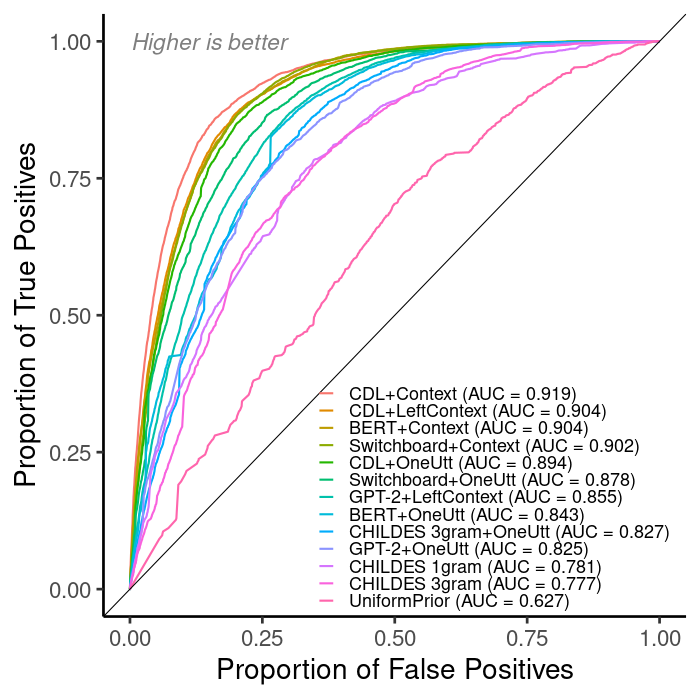

time: 3.48 s (started: 2023-01-24 12:00:39 -08:00)


In [158]:
%%R -h 700 -w 700
p1 = ggplot(scores_across_time_overview_set, 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname_with_wfst_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .21),
legend.background = element_blank(), legend.title = element_blank(), legend.text=element_text(size=18)) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('../../output/figures/roc_wfst.pdf', height=10, width=10)    

### Set Color Standards for All Plots

In [164]:
%%R
g <- ggplot_build(p1)
colors_for_13_plots = unique(g$data[[1]]$colour)
#reorder = c(1,3,2,4,5,6,7,8)
#colors_for_8_plots = colors_for_8_plots[reorder]
print(colors_for_13_plots)

 [1] "#F8766D" "#E18A00" "#BE9C00" "#8CAB00" "#24B700" "#00BE70" "#00C1AB"
 [8] "#00BBDA" "#00ACFC" "#8B93FF" "#D575FE" "#F962DD" "#FF65AC"
time: 1.34 s (started: 2023-01-24 12:08:42 -08:00)


In [526]:
%%R
models_for_13_plots = scores_per_model_wfst$model_shortname
shapes_for_13_plots = c(0:12)

time: 13.6 ms (started: 2023-02-01 11:15:00 -08:00)


## Levenshtein Distance

In [169]:
%%R
auc_by_model_lev = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_levdist = auc(roc1)))}))

scores_across_time_short_lev = merge(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance') , auc_by_model_lev)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 29 s (started: 2023-01-24 12:12:38 -08:00)


In [170]:
%%R
# get rid of tags in the model shortname
scores_across_time_short_lev = filter_model_subset(scores_across_time_short_lev, overview_set)
scores_across_time_short_lev$model_shortname = gsub('\\+Tags','', scores_across_time_short_lev$model)
# we can do this because for each model with tags, there is no model without tags in the analysis set
scores_across_time_short_lev$model_with_levdist_auc = paste0(scores_across_time_short_lev$model_shortname,' (AUC = ',
round(scores_across_time_short_lev$auc_levdist, 3),')')

time: 2.59 s (started: 2023-01-24 12:13:07 -08:00)


In [171]:
%%R
scores_across_time_short_lev$model_with_levdist_auc = paste0(scores_across_time_short_lev$model_shortname,' (AUC = ',
round(scores_across_time_short_lev$auc_levdist, 3),')')

time: 1.98 s (started: 2023-01-24 12:13:10 -08:00)


In [172]:
%%R
# sort the levels by the scores
names_per_model = aggregate(model_with_levdist_auc ~ model_shortname, scores_across_time_short_lev, unique)
scores_per_model_lev = aggregate(auc_levdist ~ model_shortname, scores_across_time_short_lev, unique)
scores_per_model_lev = merge(names_per_model, scores_per_model_lev)
scores_per_model_lev = scores_per_model_lev[order(scores_per_model_lev$auc_levdist, decreasing=T),]
print(scores_per_model_lev)
scores_across_time_short_lev$model_with_levdist_auc = factor(as.character(scores_across_time_short_lev$model_with_levdist_auc), 
                                                             levels = as.character(scores_per_model_lev$model_with_levdist_auc))



scores_per_model_lev$model_shortname = factor(scores_per_model_lev$model_shortname, levels = as.character(scores_per_model_lev$model_shortname))
scores_across_time_short_lev$model_shortname = factor(scores_across_time_short_lev$model_shortname, levels = as.character(scores_per_model_lev$model_shortname))



        model_shortname             model_with_levdist_auc auc_levdist
3           CDL+Context          CDL+Context (AUC = 0.872)   0.8724673
1          BERT+Context         BERT+Context (AUC = 0.859)   0.8593691
4       CDL+LeftContext      CDL+LeftContext (AUC = 0.851)   0.8514244
11  Switchboard+Context  Switchboard+Context (AUC = 0.846)   0.8460553
5            CDL+OneUtt           CDL+OneUtt (AUC = 0.835)   0.8350191
12   Switchboard+OneUtt   Switchboard+OneUtt (AUC = 0.813)   0.8127051
9     GPT-2+LeftContext    GPT-2+LeftContext (AUC = 0.797)   0.7972559
2           BERT+OneUtt          BERT+OneUtt (AUC = 0.788)   0.7878455
8  CHILDES 3gram+OneUtt CHILDES 3gram+OneUtt (AUC = 0.751)   0.7512518
10         GPT-2+OneUtt          GPT-2+OneUtt (AUC = 0.75)   0.7504306
7         CHILDES 3gram        CHILDES 3gram (AUC = 0.702)   0.7019570
6         CHILDES 1gram        CHILDES 1gram (AUC = 0.664)   0.6638829
13         UniformPrior         UniformPrior (AUC = 0.657)   0.6569725
time: 

In [173]:
%%R
levels(scores_per_model_lev$model_shortname) # this is the one that has to be re-ordered

 [1] "CDL+Context"          "BERT+Context"         "CDL+LeftContext"     
 [4] "Switchboard+Context"  "CDL+OneUtt"           "Switchboard+OneUtt"  
 [7] "GPT-2+LeftContext"    "BERT+OneUtt"          "CHILDES 3gram+OneUtt"
[10] "GPT-2+OneUtt"         "CHILDES 3gram"        "CHILDES 1gram"       
[13] "UniformPrior"        
time: 25.2 ms (started: 2023-01-24 12:13:14 -08:00)


In [174]:
%%R
levels(scores_across_time_short_lev$model_shortname)

 [1] "CDL+Context"          "BERT+Context"         "CDL+LeftContext"     
 [4] "Switchboard+Context"  "CDL+OneUtt"           "Switchboard+OneUtt"  
 [7] "GPT-2+LeftContext"    "BERT+OneUtt"          "CHILDES 3gram+OneUtt"
[10] "GPT-2+OneUtt"         "CHILDES 3gram"        "CHILDES 1gram"       
[13] "UniformPrior"        
time: 23.1 ms (started: 2023-01-24 12:13:14 -08:00)


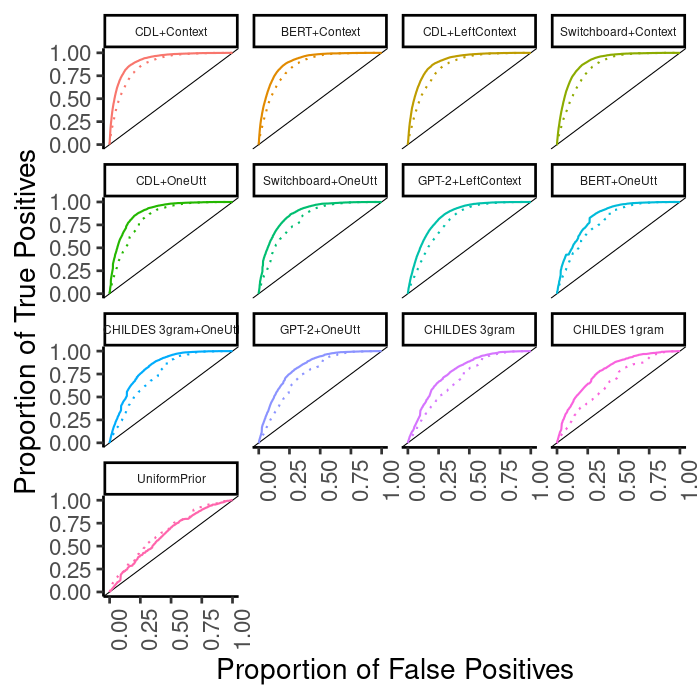

time: 7.37 s (started: 2023-01-24 12:15:15 -08:00)


In [179]:
%%R -h 700 -w 700
p1 = ggplot(filter_model_subset(scores_across_time_short_lev, overview_set), 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname), linetype = 'dashed'
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0, linetype="dotted") + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position="none", axis.text.x = element_text(angle = 90, hjust=1)
)  + geom_abline(intercept=0, slope=1
) + facet_wrap(~as.factor(model_shortname)) + geom_roc(data=filter_model_subset(scores_across_time_short_wfst,
overview_set), aes(d=set_binarized, 
m=posterior_entropy, color=model_shortname), n.cuts=0) + theme(strip.text.x = element_text(size = 12))
ggsave('../../output/figures/roc_levdist.pdf', height=10, width=10)   + scale_color_manual(
        values=colors_for_13_plots)  
print(p1)

## Visualization of Successes and Failures

In [180]:
%%R
index_cols = c('bert_token_id', 'set')
selected_cols = c('posterior_entropy', 'posterior_probability', 'posterior_rank', 'prior_entropy', 'prior_probability', 'prior_rank')
best_model = subset(scores_across_time_short, model == "CDL+Context+Tags" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(best_model) = c(index_cols, paste0('bert_', selected_cols))
base_model = subset(scores_across_time_short, model == "UniformPrior" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(base_model) = c(index_cols, paste0('uniform_', selected_cols))
model_scores_merged = merge(best_model, base_model)

time: 924 ms (started: 2023-01-24 12:16:50 -08:00)


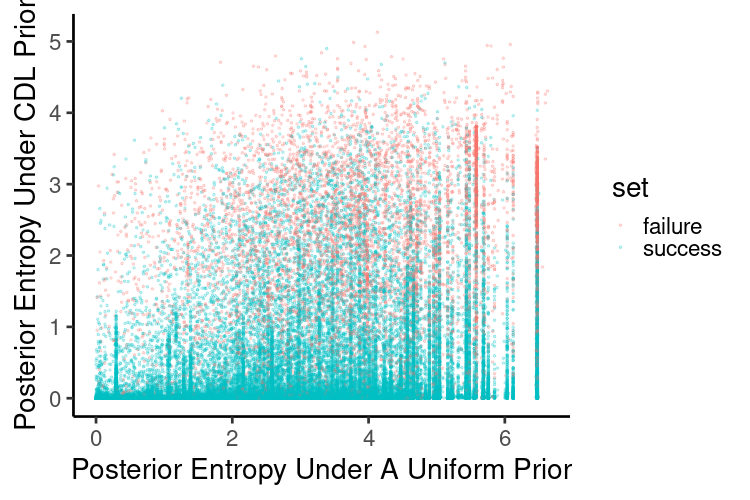

time: 910 ms (started: 2023-01-24 12:16:51 -08:00)


In [181]:
%%R -w 750 -h 500 
ggplot(model_scores_merged) + geom_point(aes(x=uniform_posterior_entropy, y=bert_posterior_entropy, color=set), alpha=.25, size=1
) + theme_classic(base_size=28) + xlab('Posterior Entropy Under A Uniform Prior') + ylab('Posterior Entropy Under CDL Prior')

## Statistical Tests for Difference in ROC curves

### Pairwise comparison of WFST ROC curves

In [182]:
%%R

models = unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model)
models[1]
roc_tests = mat.or.vec(length(models), length(models))

time: 343 ms (started: 2023-01-24 12:16:55 -08:00)


In [183]:
%%R
test = subset(scores_across_time_short, model == "Switchboard+Context" & likelihood_type == 'WFST')
nrow(test)

[1] 0
time: 130 ms (started: 2023-01-24 12:16:56 -08:00)


In [184]:
%%R
#precompute ROCs
rocs = list()
for (model_name in overview_set){
    print(model_name)
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    rocs[[model_name]] = roc(one_model$set_binarized, one_model$posterior_entropy)
}

[1] "CDL+Context+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "BERT+Context"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "CDL+OneUtt+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "BERT+OneUtt"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "Switchboard+Context+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "Switchboard+OneUtt"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "CHILDES 1gram"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "UniformPrior"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "CDL+LeftContext+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "CHILDES 3gram"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "CHILDES 3gram+OneUtt"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "GPT-2+LeftContext+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "GPT-2+OneUtt+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



time: 3.4 s (started: 2023-01-24 12:16:57 -08:00)


In [487]:
%%R

roc_ps = mat.or.vec(length(overview_set), length(overview_set))
roc_stats = mat.or.vec(length(overview_set), length(overview_set))



for (i in c(1:length(overview_set))){
    for (j in c(1:i)){
        roc1 = rocs[[overview_set[i]]]
        roc2 = rocs[[overview_set[j]]]
        rtest = roc.test(roc1, roc2, method="delong")
        roc_ps[i,j] = round(rtest$p.value, 3)        
        roc_stats [i,j] = abs(round(rtest$statistic, 3))        
    }
}    


roc_ps = data.frame(roc_ps)
names(roc_ps) = overview_set
colnames(roc_ps) = overview_set


roc_stats = data.frame(roc_stats)
names(roc_stats) = overview_set
colnames(roc_stats) = overview_set

time: 1.41 s (started: 2023-02-01 10:10:46 -08:00)


In [488]:
%%R
roc_stats

   CDL+Context+Tags BERT+Context CDL+OneUtt+Tags BERT+OneUtt
1             0.000        0.000           0.000       0.000
2             9.736        0.000           0.000       0.000
3            17.108        6.282           0.000       0.000
4            35.014       35.171          25.895       0.000
5            12.596        1.556           4.982      28.654
6            22.445       16.889          10.863      24.544
7            43.750       38.853          35.252      18.113
8            77.049       73.217          69.401      54.006
9            12.581        0.099           9.244      29.563
10           53.564       48.752          47.864      22.548
11           43.013       36.124          37.685       6.429
12           31.273       23.911          19.876       4.830
13           41.802       35.268          35.390       7.014
   Switchboard+Context+Tags Switchboard+OneUtt CHILDES 1gram UniformPrior
1                     0.000              0.000         0.000        0.00

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [489]:
%%R
roc_ps

   CDL+Context+Tags BERT+Context CDL+OneUtt+Tags BERT+OneUtt
1                 1        0.000               0           0
2                 0        1.000               0           0
3                 0        0.000               1           0
4                 0        0.000               0           1
5                 0        0.120               0           0
6                 0        0.000               0           0
7                 0        0.000               0           0
8                 0        0.000               0           0
9                 0        0.921               0           0
10                0        0.000               0           0
11                0        0.000               0           0
12                0        0.000               0           0
13                0        0.000               0           0
   Switchboard+Context+Tags Switchboard+OneUtt CHILDES 1gram UniformPrior
1                     0.000                  0         0.000            

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [498]:
%%R
roc_ps[upper.tri(test, diag=T)] = NA


time: 9.28 ms (started: 2023-02-01 10:16:51 -08:00)


In [512]:
%%R
roc_ps

   CDL+Context+Tags BERT+Context CDL+OneUtt+Tags BERT+OneUtt
1                NA           NA              NA          NA
2                 0           NA              NA          NA
3                 0        0.000              NA          NA
4                 0        0.000               0          NA
5                 0        0.120               0           0
6                 0        0.000               0           0
7                 0        0.000               0           0
8                 0        0.000               0           0
9                 0        0.921               0           0
10                0        0.000               0           0
11                0        0.000               0           0
12                0        0.000               0           0
13                0        0.000               0           0
   Switchboard+Context+Tags Switchboard+OneUtt CHILDES 1gram UniformPrior
1                        NA                 NA            NA           N

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [519]:
%%R
# pull out the pairs that 
model_names = names(roc_ps)
for (i in c(1:length(model_names))){    
    for (j in c(1:length(model_names))){
        if (!is.na(roc_ps[i,j])){
            if (roc_ps[i,j] > .05){
                print(paste(model_names[i], '-', model_names[j], roc_ps[i,j], roc_stats[i,j]))
            }
        }
    }
}


[1] "Switchboard+Context+Tags - BERT+Context 0.12 1.556"
[1] "CDL+LeftContext+Tags - BERT+Context 0.921 0.099"
[1] "CDL+LeftContext+Tags - Switchboard+Context+Tags 0.193 1.302"
[1] "CHILDES 3gram - CHILDES 1gram 0.364 0.908"
[1] "GPT-2+OneUtt+Tags - CHILDES 3gram+OneUtt 0.292 1.055"
time: 59.6 ms (started: 2023-02-01 10:28:01 -08:00)


### Paired Comparison of Likelihoods Within Model

In [190]:
%%R
#precompute ROCs
levdist_rocs = list()
for (model_name in overview_set){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    levdist_rocs[[model_name]] = roc(one_model$set_binarized, one_model$posterior_entropy)
}

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 2.66 s (started: 2023-01-24 12:17:22 -08:00)


In [191]:
%%R
paired_comparison =  do.call('rbind', lapply(overview_set, function(model_name){    
    roc1 = rocs[[model_name]]
    roc2 = levdist_rocs[[model_name]]
    rtest = roc.test(roc1, roc2, method="delong")    

    prob = round(rtest$p.value, 3)        
    stat = abs(round(rtest$statistic, 3))    
    return(data.frame(model_name, prob, stat))        
}))

paired_comparison

                  model_name prob   stat
D           CDL+Context+Tags    0 18.320
D1              BERT+Context    0 17.351
D2           CDL+OneUtt+Tags    0 21.193
D3               BERT+OneUtt    0 16.791
D4  Switchboard+Context+Tags    0 21.545
D5        Switchboard+OneUtt    0 21.506
D6             CHILDES 1gram    0 27.436
D7              UniformPrior    0  6.159
D8      CDL+LeftContext+Tags    0 19.740
D9             CHILDES 3gram    0 19.107
D10     CHILDES 3gram+OneUtt    0 22.063
D11   GPT-2+LeftContext+Tags    0 18.495
D12        GPT-2+OneUtt+Tags    0 21.079
time: 298 ms (started: 2023-01-24 12:17:27 -08:00)


/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [192]:
%%R
print(auc(rocs[['UniformPrior']]))
print(auc(levdist_rocs[['UniformPrior']]))

Area under the curve: 0.6272
Area under the curve: 0.657
time: 21.6 ms (started: 2023-01-24 12:17:31 -08:00)


In [193]:
%%R
roc.test(rocs[['UniformPrior']], levdist_rocs[['UniformPrior']], method="delong") 


	DeLong's test for two ROC curves

data:  rocs[["UniformPrior"]] and levdist_rocs[["UniformPrior"]]
D = -6.1586, df = 101528, p-value = 7.364e-10
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.6272221   0.6569725 

time: 67.5 ms (started: 2023-01-24 12:17:32 -08:00)


# Analysis 2: Do the models find the same words as adults?

## Prior and Posterior Table

In [194]:
%%R
unique(successes_across_time$likelihood_type)

[1] "Levenshtein Distance" "WFST"                
time: 83.7 ms (started: 2023-01-24 12:17:47 -08:00)


### WFST

In [285]:
%%R
# note that we don't need to separate the prior computations by the likelihood type-- it's the prior!

prior_probs = aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})
posterior_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){mean(-1 * log(x, base = 2))})
prior_probs = merge(prior_probs, posterior_probs)
    

subset(prior_probs, model %in% overview_set)

                      model prior_probability posterior_probability
1              BERT+Context          4.626855             1.0244256
2               BERT+OneUtt          7.347527             1.8142604
4          CDL+Context+Tags          3.301907             0.6283817
5      CDL+LeftContext+Tags          4.232565             0.8626878
11          CDL+OneUtt+Tags          5.059460             1.0923931
16            CHILDES 1gram          8.790043             2.2592094
17            CHILDES 3gram          7.809870             2.4267939
18     CHILDES 3gram+OneUtt          7.939862             1.8089116
21   GPT-2+LeftContext+Tags          6.446343             1.9043518
24        GPT-2+OneUtt+Tags          7.861162             2.4686988
25 Switchboard+Context+Tags          4.096072             0.8492632
26       Switchboard+OneUtt          6.462003             1.5190849
27             UniformPrior         12.965243             4.6138573
time: 2.02 s (started: 2023-01-25 13:53:39 -08:0

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [286]:
%%R
posterior_probs_sd = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){sem(-1 * log(x, base = 2))})
names(posterior_probs_sd) = c('model', 'posterior_probability_sem')


prior_probs_sem = aggregate(prior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){sem(-1 * log(x, base = 2))})
names(prior_probs_sem) = c('model', 'prior_probability_sem')

prior_probs = merge(merge(prior_probs, posterior_probs_sd), prior_probs_sem)
prior_probs = prior_probs[order(prior_probs$prior_probability),]
prior_probs$prior_low = prior_probs$prior_probability - prior_probs$prior_probability_sem
prior_probs$prior_high = prior_probs$prior_probability + prior_probs$prior_probability_sem
prior_probs$posterior_low = prior_probs$posterior_probability - prior_probs$posterior_probability_sem
prior_probs$posterior_high = prior_probs$posterior_probability + prior_probs$posterior_probability_sem
prior_probs


                        model prior_probability posterior_probability
4            CDL+Context+Tags          3.301907             0.6283817
7      CDL+Older+Context+Tags          3.319319             0.6360412
3                 CDL+Context          3.387972             0.6395481
6           CDL+Older+Context          3.389654             0.6614732
13   CDL+Younger+Context+Tags          3.488081             0.6630180
12        CDL+Younger+Context          3.493721             0.6547977
25   Switchboard+Context+Tags          4.096072             0.8492632
5        CDL+LeftContext+Tags          4.232565             0.8626878
1                BERT+Context          4.626855             1.0244256
11            CDL+OneUtt+Tags          5.059460             1.0923931
9       CDL+Older+OneUtt+Tags          5.064600             1.1016046
10                 CDL+OneUtt          5.169880             1.1154794
8            CDL+Older+OneUtt          5.241232             1.1315326
14         CDL+Young

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


     2.4444914      2.4929061
18     1.7913131      1.8265102
22     2.4399645      2.4897180
16     2.2424219      2.2759968
23     4.8441868      5.1208539
19     6.1079822      6.6266674
27     4.5941910      4.6335236
time: 1.74 s (started: 2023-01-25 13:54:10 -08:00)


In [287]:
%%R
# try bootstrapping it instead
library(boot)

fc <- function(x,i ){
	return(mean(x[i]))
}

x = rnorm(1000)
print(x[1:10])
boot.ci(boot(x, fc, R=1000), type="basic")$basic[,4:5]

# get the 95% ci

 [1] -1.50515617 -0.74863606  0.71093814 -0.55640578  0.18067383  1.05727369
 [7]  0.26979940  0.98078859  1.90384138 -0.01544892
[1] -0.03111552  0.09693074
time: 147 ms (started: 2023-01-25 13:54:34 -08:00)


In [288]:
%%R
library('parallel')
fc <- function(x,i ){
	return(mean(x[i]))
}

wfst_df = subset(successes_across_time, likelihood_type == 'WFST')
df_split = split(wfst_df, wfst_df$model) 
results = do.call('rbind', mclapply(df_split, function(df){
    x = -1 * log(df$prior_probability, base = 2)
    ci = boot.ci(boot(x, fc, R=10), type="basic")$basic
    return(data.frame(model = unique(df$model), low=ci[4], high=ci[5]))
}, mc.cores=24))



time: 31.7 s (started: 2023-01-25 13:54:35 -08:00)


In [289]:
%%R
posterior_mean_rankings = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){mean_posterior_rank = mean(x)})
names(posterior_mean_rankings) = c('model', 'likelihood_type', 'mean_posterior_rank')

prior_mean_rankings = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){mean_prior_rank = mean(x)})
names(prior_mean_rankings) = c('model', 'likelihood_type', 'mean_prior_rank')

prior_top1 = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){prior_percenttop1 = mean(x ==  0)})
names(prior_top1) = c('model', 'likelihood_type', 'prior_percenttop1')

posterior_median_rankings = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){median_posterior_rank = median(x)+1})
names(posterior_median_rankings) = c('model', 'likelihood_type', 'median_posterior_rank')
# 0-indexed coming from Python, so incrementing by one


prior_median_rankings = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){median_prior_rank = median(x)+1})
names(prior_median_rankings) = c('model', 'likelihood_type', 'median_prior_rank')
# 0-indexed coming from Pythong, so incrementing by one

top_1 = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){percenttop1 = mean(x ==  0)})
names(top_1) = c('model', 'likelihood_type','percenttop1')


rankings = merge(merge(merge(prior_mean_rankings, posterior_mean_rankings, 
    by=c('model', 'likelihood_type')), top_1), prior_top1)

rankings = merge(rankings, posterior_median_rankings, by=c('model', 'likelihood_type'))
rankings = merge(rankings, prior_median_rankings, by=c('model', 'likelihood_type'))

rankings = rankings[order(rankings$mean_prior_rank),]
subset(rankings, model %in% overview_set)

                      model      likelihood_type mean_prior_rank
7          CDL+Context+Tags Levenshtein Distance        50.20670
8          CDL+Context+Tags                 WFST        50.20670
9      CDL+LeftContext+Tags Levenshtein Distance        88.30129
10     CDL+LeftContext+Tags                 WFST        88.30129
49 Switchboard+Context+Tags Levenshtein Distance       110.45985
50 Switchboard+Context+Tags                 WFST       110.45985
21          CDL+OneUtt+Tags Levenshtein Distance       124.30781
22          CDL+OneUtt+Tags                 WFST       124.30781
1              BERT+Context Levenshtein Distance       140.98744
2              BERT+Context                 WFST       140.98744
31            CHILDES 1gram Levenshtein Distance       314.08503
32            CHILDES 1gram                 WFST       314.08503
51       Switchboard+OneUtt Levenshtein Distance       362.90048
52       Switchboard+OneUtt                 WFST       362.90048
41   GPT-2+LeftContext+Ta

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [299]:
%%R
for_table = subset(merge(prior_probs, subset(rankings, likelihood_type == 'WFST') , all.x=T), model %in% overview_set)
for_table
for_table$prior_probability = round(for_table$prior_probability, 2)
for_table$posterior_probability = round(for_table$posterior_probability, 2)
for_table$prior_percenttop1 = round(for_table$prior_percenttop1, 2)
for_table$mean_prior_rank = round(for_table$mean_prior_rank, 2)
for_table$mean_posterior_rank = round(for_table$mean_posterior_rank, 2)
for_table$percenttop1 = round(for_table$percenttop1, 2)

time: 11.2 ms (started: 2023-01-25 14:18:48 -08:00)


In [300]:
%%R
unique(for_table$likelihood_type)

[1] "WFST"
time: 12.6 ms (started: 2023-01-25 14:18:53 -08:00)


In [301]:
%%R
nrow(for_table)

[1] 13
time: 13 ms (started: 2023-01-25 14:19:07 -08:00)


R[write to console]: Saving 6.67 x 6.67 in image



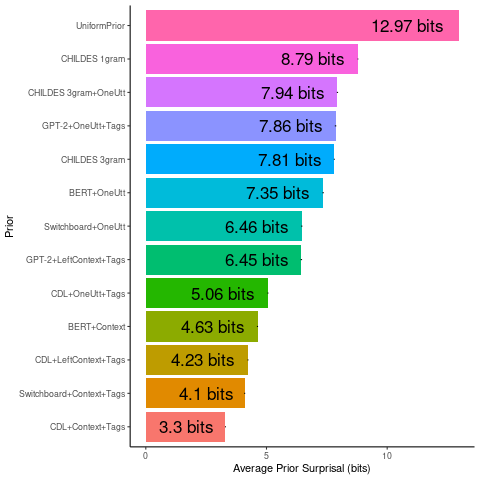

time: 356 ms (started: 2023-01-25 14:19:21 -08:00)


In [302]:
%%R
table_for_ordering = subset(for_table, likelihood_type == 'WFST')
table_for_ordering = table_for_ordering[order(table_for_ordering$prior_probability),]

for_table$model  = factor(for_table$model, levels = table_for_ordering$model)
for_table$prior_probability_bits = paste(for_table$prior_probability, 'bits')

p1 =  ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=prior_probability, fill=model), stat="identity"
) + coord_flip() + ylab('Average Prior Surprisal (bits)') + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_errorbar(aes(x=model, ymin=prior_low, ymax = prior_high), width = 0
)+  geom_text(aes(x=model, y=prior_probability, label=prior_probability_bits), hjust=1.2, size=6
) 
print(p1)

ggsave('../../output/figures/prior_bar_chart.pdf')

R[write to console]: Saving 6.67 x 6.67 in image



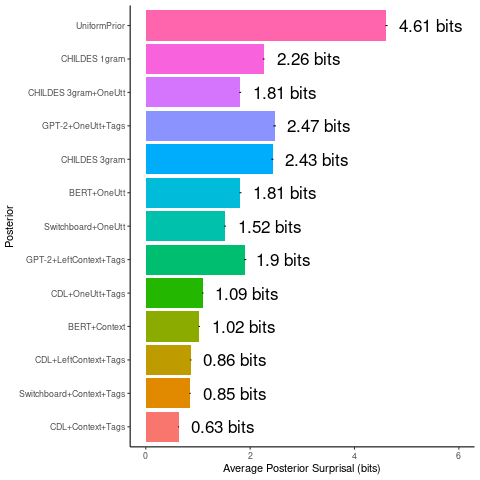

time: 364 ms (started: 2023-01-25 14:19:25 -08:00)


In [303]:
%%R
for_table$posterior_probability_bits = paste(for_table$posterior_probability, 'bits')

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=posterior_probability, fill=model), stat="identity"
)  + ylab('Average Posterior Surprisal (bits)') + xlab('Posterior') + theme_classic() +
theme(legend.position="none") + geom_errorbar(aes(x=model, ymin=posterior_low, ymax = posterior_high), width = 0
)+  geom_text(aes(x=model, y=posterior_probability, label=posterior_probability_bits), hjust=-.2, size=6
)  + coord_flip(ylim=c(0, 6))

print(p1)
ggsave('../../output/figures/posterior_bar_chart.pdf')

R[write to console]: Saving 6.67 x 6.67 in image



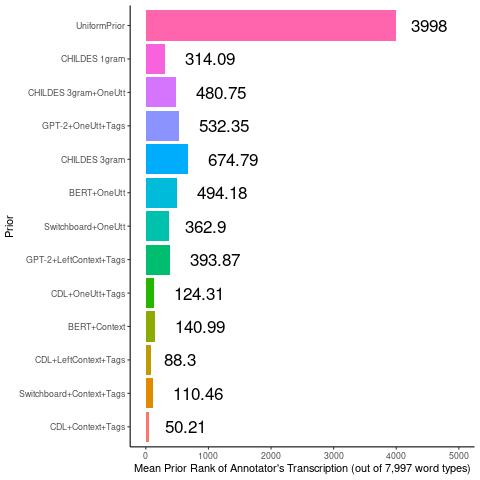

time: 342 ms (started: 2023-01-25 14:19:28 -08:00)


In [304]:
%%R
p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=mean_prior_rank, fill=model), stat="identity"
)  + ylab("Mean Prior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=mean_prior_rank, label=mean_prior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 5000)) 
print(p1)
ggsave('../../output/figures/prior_rank.pdf')


R[write to console]: Saving 6.67 x 6.67 in image



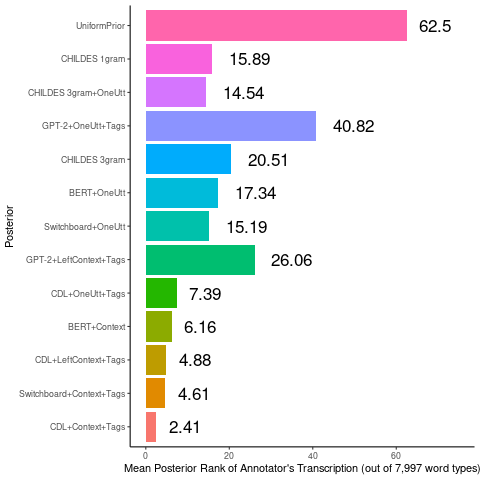

time: 338 ms (started: 2023-01-25 14:19:34 -08:00)


In [305]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=mean_posterior_rank, fill=model), stat="identity"
)  + ylab("Mean Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Posterior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=mean_posterior_rank, label=mean_posterior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 75)) 
print(p1)
ggsave('../../output/figures/posterior_rank.pdf')

### Compare Likelihood Functions

In [306]:
%%R
library(ggpattern)

p1 = ggplot(for_table) + geom_bar(aes(x=model, y=mean_posterior_rank, fill=model, alpha=likelihood_type), stat="identity", position="dodge"
)  + ylab("Mean Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(data=subset(for_table, likelihood_type =='WFST'), aes(x=model, y=mean_posterior_rank, 
label=mean_posterior_rank), hjust=-.4, size=6, vjust=-.2,                                          
position = "dodge") + geom_text(data=subset(for_table, likelihood_type =='Levenshtein Distance'), aes(x=model, y=mean_posterior_rank, 
label=mean_posterior_rank), hjust=-.4, size=6, vjust=1.5,                                          
position = "dodge")  + coord_flip(ylim =c(0, 200)) 
print(p1)
ggsave('../../output/figures/posterior_rank_by_likelihood.pdf')

R[write to console]: Error in library(ggpattern) : there is no package called ‘ggpattern’

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 13. Consider
specifying shapes manually if you must have them. 

R[write to console]: 2: Removed 42 rows containing missing values (geom_point). 

R[write to console]: 3: 
R[write to console]: In mclapply(df_split, function(df) { :
R[write to console]: 
 
R[write to console]:  scheduled core 3 encountered error in user code, all values of the job will be affected




Error in library(ggpattern) : there is no package called ‘ggpattern’
time: 18.3 ms (started: 2023-01-25 14:19:37 -08:00)


### Median Ranks

In [307]:
%%R
# aggregate number by rank by mode
number_by_rank_by_model = aggregate(posterior_probability ~ posterior_rank + model,
    subset(successes_across_time, likelihood_type == 'WFST') , length) 
names(number_by_rank_by_model) = c('posterior_rank' , 'model', 'number_items')

number_by_rank_by_model = subset(number_by_rank_by_model, model %in% overview_set)
number_by_rank_by_model$model  = factor(number_by_rank_by_model$model, levels = table_for_ordering$model)


time: 1.91 s (started: 2023-01-25 14:20:07 -08:00)


R[write to console]: Saving 6.67 x 6.67 in image



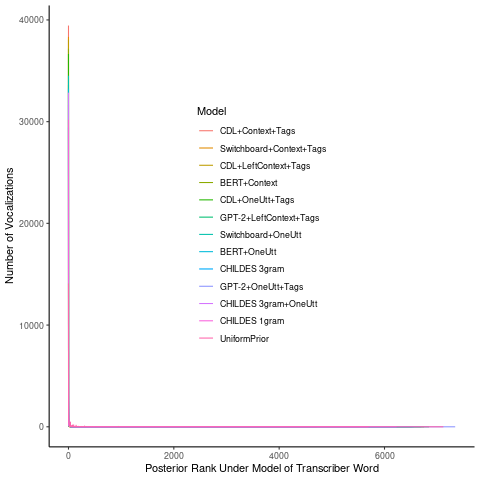

time: 764 ms (started: 2023-01-25 14:20:09 -08:00)


In [308]:
%%R
p1 = ggplot(number_by_rank_by_model) + geom_line(aes(
 x=posterior_rank, y = number_items, color=model))  + theme_classic(
) + ylab('Number of Vocalizations') + xlab('Posterior Rank Under Model of Transcriber Word'
) + theme(legend.position = c(.5, .5)) + labs(color='Model')
ggsave('../../output/figures/density_posterior_rank_full.pdf')
print(p1)

R[write to console]: Saving 6.67 x 6.67 in image



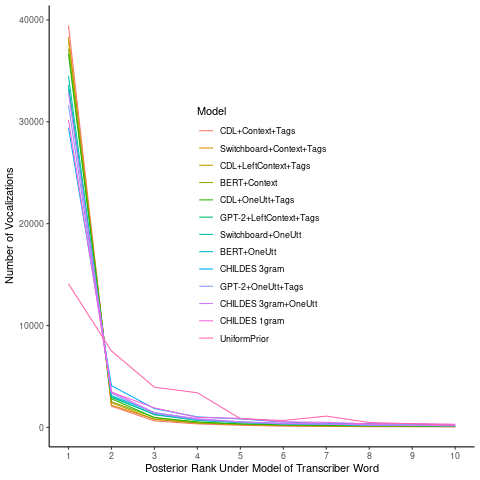

time: 731 ms (started: 2023-01-25 14:20:10 -08:00)


In [309]:
%%R
p1 = ggplot(subset(number_by_rank_by_model,
posterior_rank <= 9)) + geom_line(aes(
 x=posterior_rank+1, y = number_items, color=model))  + theme_classic(
) + ylab('Number of Vocalizations') + xlab('Posterior Rank Under Model of Transcriber Word'
) + theme(legend.position = c(.5, .5)) + labs(color='Model') + scale_x_continuous(
    breaks = c(1:10), labels = c(1:10))
ggsave('../../output/figures/density_posterior_rank_10.pdf')
print(p1)

R[write to console]: Saving 6.67 x 6.67 in image



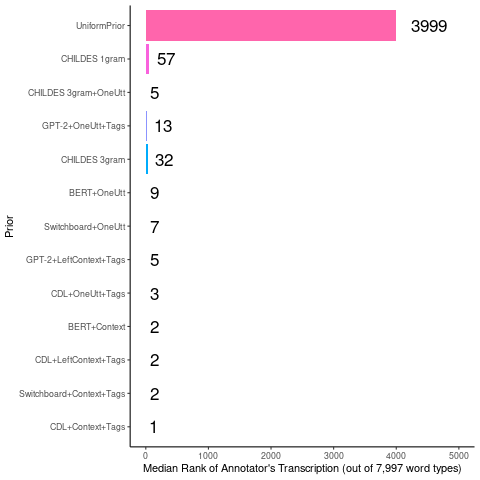

time: 330 ms (started: 2023-01-25 14:20:13 -08:00)


In [310]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=median_prior_rank, fill=model), stat="identity"
)  + ylab("Median Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=median_prior_rank, label=median_prior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 5000)) 
print(p1)
ggsave('../../output/figures/median_prior_rank.pdf')



R[write to console]: Saving 6.67 x 6.67 in image



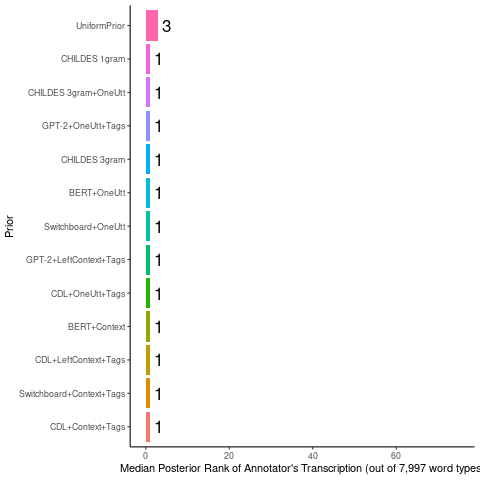

time: 346 ms (started: 2023-01-25 14:20:17 -08:00)


In [311]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=median_posterior_rank, fill=model), stat="identity"
)  + ylab("Median Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=median_posterior_rank, label=median_posterior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 75)) 
print(p1)
ggsave('../../output/figures/median_posterior_rank.pdf')

### Levenshtein Distance (Posteriors Only)

In [349]:
%%R
lev_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean(-1 * log(x, base = 2))})
lev_rankings = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean_posterior_rank = mean(x)})
names(lev_rankings) = c('model', 'mean_posterior_rank')
lev_top_1 = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean_posterior_rank = mean(x ==  0)})
names(lev_top_1) = c('model', 'percenttop1')
lev_for_table = subset(merge(merge(lev_probs, lev_rankings, all.x=T), lev_top_1), model %in% overview_set)
lev_for_table[order(lev_for_table$posterior_probability),]

                      model posterior_probability mean_posterior_rank
4          CDL+Context+Tags              1.151873            7.886872
25 Switchboard+Context+Tags              1.520166           13.949501
5      CDL+LeftContext+Tags              1.544839           15.579587
1              BERT+Context              1.691454           18.517299
11          CDL+OneUtt+Tags              1.900132           23.373504
26       Switchboard+OneUtt              2.533751           42.926535
18     CHILDES 3gram+OneUtt              2.725288           41.367620
2               BERT+OneUtt              2.832998           46.503691
21   GPT-2+LeftContext+Tags              3.027876           62.244111
17            CHILDES 3gram              3.564943           55.646873
16            CHILDES 1gram              3.762499           48.995139
24        GPT-2+OneUtt+Tags              3.808643           94.308398
27             UniformPrior              4.965982          138.308080
   percenttop1
4    

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [350]:
%%R
wfst_for_table = subset(for_table, likelihood_type == 'WFST')[,c('model', 'prior_probability', 'mean_prior_rank', 'prior_percenttop1', 'posterior_probability','mean_posterior_rank','percenttop1')]
names(wfst_for_table) = c('model', 'prior_surp', 'mean_prior_rank', 'prior_percenttop1', 'wfst_posterior_surp','wfst_mean_posterior_rank', 'wfst_percenttop1')
# wfst_for_table

time: 9.67 ms (started: 2023-01-25 15:59:51 -08:00)


In [351]:
%%R
lev_for_table$posterior_probability = round(lev_for_table$posterior_probability, 2)
lev_for_table$mean_posterior_rank = round(lev_for_table$mean_posterior_rank, 2)
lev_for_table$percent_top_1 = round(lev_for_table$percenttop1, 2)
lev_for_table = lev_for_table[,c('model','posterior_probability','mean_posterior_rank', 'percent_top_1')]
lev_for_table =  lev_for_table[order(lev_for_table$posterior_probability),]
names(lev_for_table) = c('model', 'levdist_posterior_surp', 'levdist_mean_posterior_rank', 'levdist_percenttop1')
lev_for_table

                      model levdist_posterior_surp levdist_mean_posterior_rank
4          CDL+Context+Tags                   1.15                        7.89
25 Switchboard+Context+Tags                   1.52                       13.95
5      CDL+LeftContext+Tags                   1.54                       15.58
1              BERT+Context                   1.69                       18.52
11          CDL+OneUtt+Tags                   1.90                       23.37
26       Switchboard+OneUtt                   2.53                       42.93
18     CHILDES 3gram+OneUtt                   2.73                       41.37
2               BERT+OneUtt                   2.83                       46.50
21   GPT-2+LeftContext+Tags                   3.03                       62.24
17            CHILDES 3gram                   3.56                       55.65
16            CHILDES 1gram                   3.76                       49.00
24        GPT-2+OneUtt+Tags                   3.81  

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [352]:
%%R
for_table_combined = merge(wfst_for_table, lev_for_table)
for_table_combined = for_table_combined[order(for_table_combined$wfst_posterior_surp),]
write.csv(for_table_combined, '../../output/csv/surprisal_table.csv', row.names=F)

time: 14.7 ms (started: 2023-01-25 15:59:55 -08:00)


In [220]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

successes_across_time_wide =  spread(successes_across_time[,c('model','prior_probability',
'bert_token_id','likelihood_type')], model, prior_probability)
successes_across_time_wide = subset(successes_across_time_wide, likelihood_type == 'WFST')
head(successes_across_time_wide)

   bert_token_id likelihood_type BERT+Context  BERT+OneUtt  CDL+Context
2          10577            WFST 3.667992e-06 6.627167e-05 8.410694e-07
4          39428            WFST 2.478826e-04 1.482735e-04 4.409806e-04
6          39594            WFST 1.482284e-02 1.482735e-04 2.243443e-01
8          41265            WFST 7.339016e-01 2.187236e-02 7.561503e-01
10         41266            WFST 3.372385e-01 3.032036e-04 3.089629e-01
12         41756            WFST 6.015850e-06 3.048956e-06 8.208628e-06
   CDL+Context+Tags CDL+LeftContext+Tags CDL+Older+Context
2      3.087818e-06         5.092399e-02      3.598957e-06
4      1.382378e-03         3.639143e-03      9.209570e-04
6      8.003053e-01         1.809391e-03      5.187610e-01
8      4.111795e-01         1.334138e-01      8.682773e-01
10     2.215365e-01         7.047070e-03      4.889882e-01
12     6.513209e-05         6.184664e-06      3.451623e-05
   CDL+Older+Context+Tags CDL+Older+OneUtt CDL+Older+OneUtt+Tags   CDL+OneUtt
2    

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [221]:
%%R

model_names = overview_set
print('Model names:')
print(model_names)

for (model_name in model_names){
    successes_across_time_wide[[model_name]] = as.numeric(successes_across_time_wide[[model_name]])
}

successes_across_time_wide_nona = drop_na(successes_across_time_wide)
print(dim(successes_across_time_wide_nona))

[1] "Model names:"
 [1] "CDL+Context+Tags"         "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "BERT+OneUtt"             
 [5] "Switchboard+Context+Tags" "Switchboard+OneUtt"      
 [7] "CHILDES 1gram"            "UniformPrior"            
 [9] "CDL+LeftContext+Tags"     "CHILDES 3gram"           
[11] "CHILDES 3gram+OneUtt"     "GPT-2+LeftContext+Tags"  
[13] "GPT-2+OneUtt+Tags"       
[1] 2412   29
time: 44.4 ms (started: 2023-01-24 12:24:14 -08:00)


In [222]:
%%R
unique(successes_across_time_wide_nona$likelihood_type)

[1] "WFST"
time: 8.93 ms (started: 2023-01-24 12:24:14 -08:00)


### t-test Pairwise Model Comparison for WFST

In [223]:
%%R
#Pairwise paired t-test between all of the models with WFST only

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rval = t.test(
                successes_across_time_wide_nona[[model_name]], 
                successes_across_time_wide_nona[[comparison_model_name]],
              paired=T)$p.value
            rvs[model_idx, comparison_model_idx] = rval
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

                         CDL+Context+Tags  BERT+Context CDL+OneUtt+Tags
CDL+Context+Tags                       NA 2.708571e-240   1.708678e-204
BERT+Context                2.708571e-240            NA    1.738200e-01
CDL+OneUtt+Tags             1.708678e-204  1.738200e-01              NA
BERT+OneUtt                  0.000000e+00 4.310615e-106   4.652669e-105
Switchboard+Context+Tags    5.833989e-178  5.188126e-69    4.767178e-27
Switchboard+OneUtt          8.947930e-306  6.461674e-35    4.608297e-77
CHILDES 1gram                0.000000e+00 6.479856e-174   1.006323e-157
UniformPrior                 0.000000e+00 6.264859e-177   6.010638e-161
CDL+LeftContext+Tags         7.261345e-93  6.060913e-48    2.547925e-87
CHILDES 3gram                0.000000e+00 1.584047e-150   3.612054e-146
CHILDES 3gram+OneUtt         0.000000e+00 9.410780e-103   1.266663e-122
GPT-2+LeftContext+Tags      5.586446e-278  6.151403e-29    1.682592e-22
GPT-2+OneUtt+Tags            0.000000e+00 2.950781e-104   6.5813

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


### Prior Surprisal Across Ages Plots

In [224]:
%R mean_surprisal_by_age = aggregate(prior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model', 'likelihood_type','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood_type','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,likelihood_type,prior_surprisal_mean,prior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,7.274761,0.115150
2,1.0,BERT+Context,WFST,7.274761,0.115150
3,1.0,BERT+OneUtt,Levenshtein Distance,11.540593,0.109994
4,1.0,BERT+OneUtt,WFST,11.540593,0.109994
5,1.0,CDL+Context,Levenshtein Distance,4.057722,0.105941
...,...,...,...,...,...
302,3.5,Switchboard+Context+Tags,WFST,3.559659,0.082072
303,3.5,Switchboard+OneUtt,Levenshtein Distance,5.060470,0.091788
304,3.5,Switchboard+OneUtt,WFST,5.060470,0.091788
305,3.5,UniformPrior,Levenshtein Distance,12.965243,0.000000


time: 5.84 s (started: 2023-01-24 12:24:14 -08:00)


In [225]:
%%R
overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

time: 31.9 ms (started: 2023-01-24 12:24:20 -08:00)


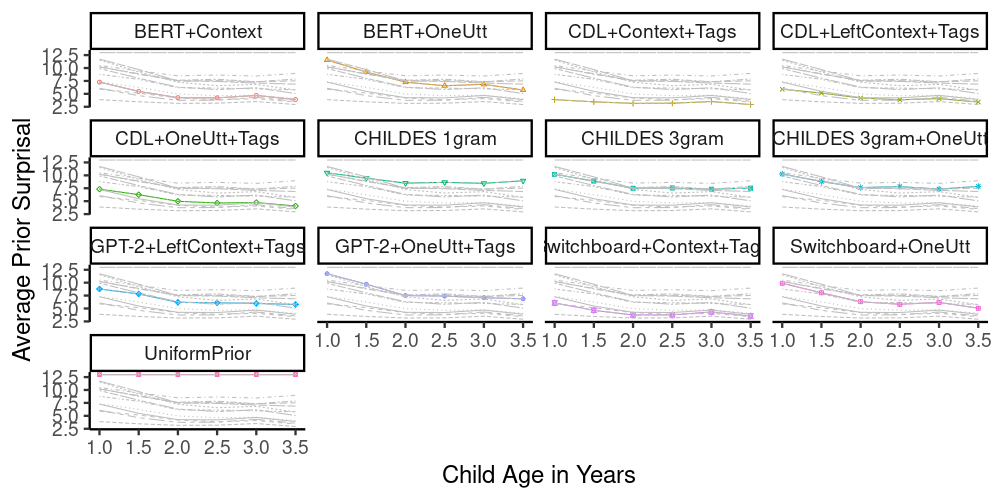

time: 1.05 s (started: 2023-01-24 12:24:20 -08:00)


In [226]:
%%R -w 1000 -h 500
ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none') + scale_shape_manual(values=1:nlevels(as.factor(overview_mean_surprisal_by_age$model))
    ) + scale_color_discrete()

# # Best performing CDL Context all/all, CHILDES 1gram and Uniform Prior 

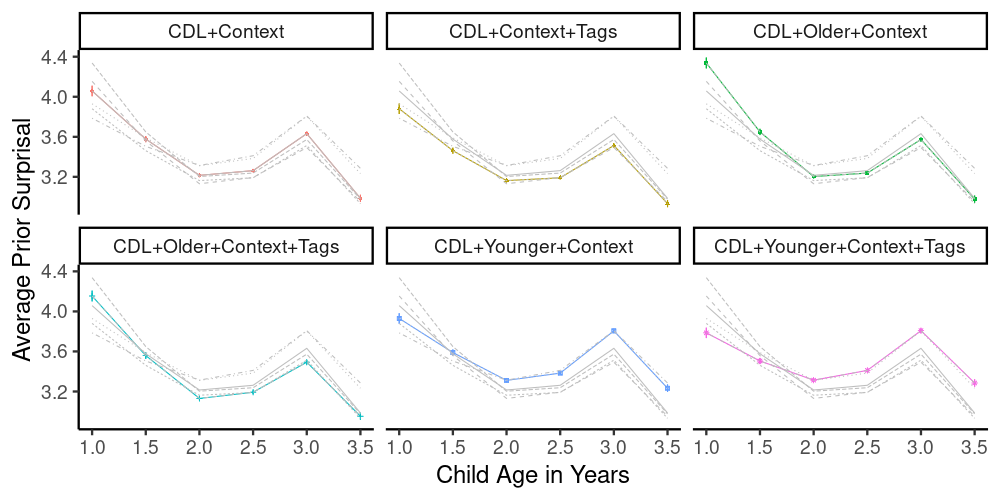

time: 463 ms (started: 2023-01-24 12:24:21 -08:00)


In [227]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')



## Posterior

In [228]:
%R mean_surprisal_by_age = aggregate(posterior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','likelihood','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
#%R print(mean_surprisal_by_age)

,age,model,likelihood,posterior_surprisal_mean,posterior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,4.338195,0.114457
2,1.0,BERT+Context,WFST,2.877891,0.095620
3,1.0,BERT+OneUtt,Levenshtein Distance,7.319938,0.151035
4,1.0,BERT+OneUtt,WFST,5.117900,0.126537
5,1.0,CDL+Context,Levenshtein Distance,2.334840,0.087965
...,...,...,...,...,...
302,3.5,Switchboard+Context+Tags,WFST,0.392354,0.030414
303,3.5,Switchboard+OneUtt,Levenshtein Distance,1.260790,0.058068
304,3.5,Switchboard+OneUtt,WFST,0.724214,0.040052
305,3.5,UniformPrior,Levenshtein Distance,3.708417,0.070411


time: 5.89 s (started: 2023-01-24 12:24:22 -08:00)


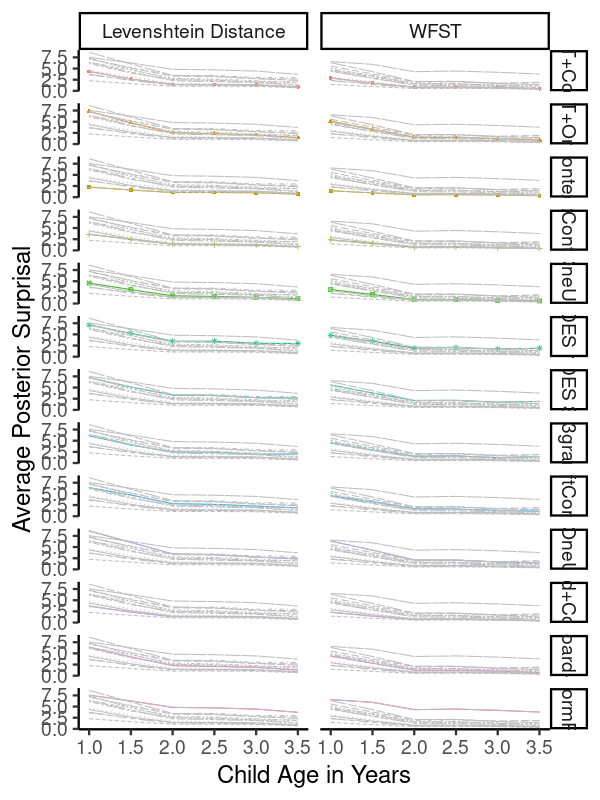

time: 1.22 s (started: 2023-01-24 12:24:28 -08:00)


In [229]:
%%R -w 600 -h 800

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_grid(model~likelihood) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


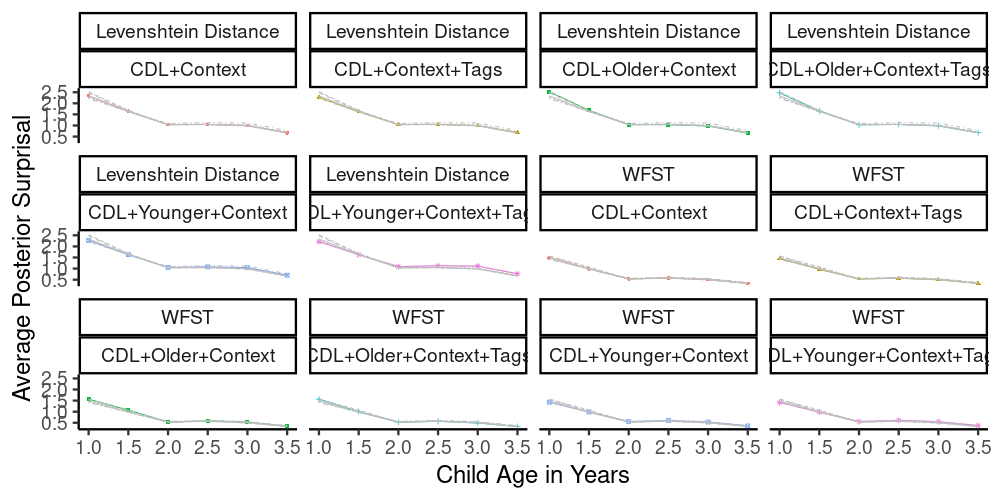

time: 1.47 s (started: 2023-01-24 12:24:29 -08:00)


In [230]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(likelihood~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


In [231]:
%%R
unique(as.character(mean_surprisal_by_age$model))

 [1] "BERT+Context"               "BERT+OneUtt"               
 [3] "CDL+Context"                "CDL+Context+Tags"          
 [5] "CDL+LeftContext+Tags"       "CDL+Older+Context"         
 [7] "CDL+Older+Context+Tags"     "CDL+Older+OneUtt"          
 [9] "CDL+Older+OneUtt+Tags"      "CDL+OneUtt"                
[11] "CDL+OneUtt+Tags"            "CDL+Younger+Context"       
[13] "CDL+Younger+Context+Tags"   "CDL+Younger+OneUtt"        
[15] "CDL+Younger+OneUtt+Tags"    "CHILDES 1gram"             
[17] "CHILDES 3gram"              "CHILDES 3gram+OneUtt"      
[19] "GPT-2+Bidirectional+Tags"   "GPT-2+LeftContext"         
[21] "GPT-2+LeftContext+Tags"     "GPT-2+OneUtt"              
[23] "GPT-2+OneUtt+Bidirectional" "GPT-2+OneUtt+Tags"         
[25] "Switchboard+Context+Tags"   "Switchboard+OneUtt"        
[27] "UniformPrior"              
time: 49.6 ms (started: 2023-01-24 12:24:30 -08:00)


In [232]:
%%R
mean_surprisal_by_age$model_shortname = gsub('\\+Tags', '', mean_surprisal_by_age$model)

time: 4.32 ms (started: 2023-01-24 12:24:30 -08:00)


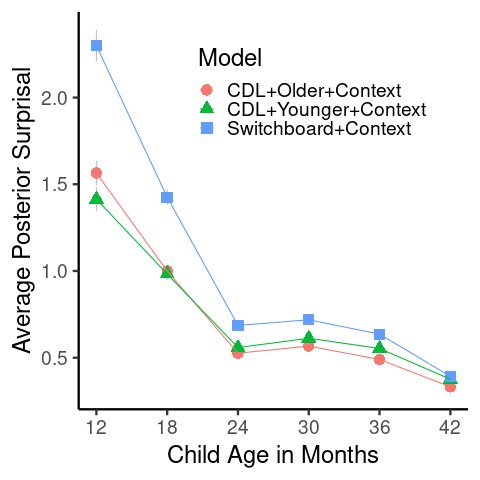

time: 400 ms (started: 2023-01-24 12:24:30 -08:00)


In [233]:
%%R 

selected_models = c('CDL+Younger+Context+Tags', 'CDL+Older+Context+Tags',
                   'Switchboard+Context+Tags')

mean_surprisal_by_age$age_in_months = mean_surprisal_by_age$age * 12

p1 =  ggplot(subset(mean_surprisal_by_age, likelihood == 'WFST' &  model %in% selected_models)
    ) + geom_errorbar(aes(x=age_in_months, ymin=posterior_surprisal_mean - posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + posterior_surprisal_sem), color="gray",  width=0) + geom_point(aes(
    x=age_in_months, y=posterior_surprisal_mean, color=model_shortname,
    shape = model_shortname), size=5) + geom_line(aes(x=age_in_months, y=posterior_surprisal_mean, color=model_shortname)
    )  + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Months') + theme(
    legend.position=c(.6, .8))  +  guides(shape = guide_legend(title = "Model"), color = guide_legend(title = "Model")
    ) + scale_x_continuous( breaks = seq(from=6, to=48, by=6), labels= seq(from=6, to=48, by=6))

ggsave('../../output/figures/posterior_surprisal_by_age.pdf', height=6, width=8)
p1


In [234]:
scores_across_time_short.drop_duplicates(subset=['bert_token_id']).set.value_counts()

success    44021
failure     6756
Name: set, dtype: int64

time: 77.2 ms (started: 2023-01-24 12:24:31 -08:00)


In [235]:
%%R
age_test_dataset = subset(successes_across_time, model %in% c('CDL+Younger+Context+Tags', 'CDL+Older+Context+Tags'))

time: 2.29 s (started: 2023-01-24 12:24:31 -08:00)


In [236]:
%%R
names(age_test_dataset)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "model_remapped"       
time: 30.2 ms (started: 2023-01-24 12:24:33 -08:00)


In [237]:
%%R
max(age_test_dataset$posterior_probability)
age_test_dataset$posterior_surprisal = -1 * log(age_test_dataset$posterior_probability, base =2) 

time: 7.05 ms (started: 2023-01-24 12:24:33 -08:00)


In [238]:
%%R
library('lmerTest')

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




time: 55.8 ms (started: 2023-01-24 12:24:33 -08:00)


In [239]:
%%R
lm1 = lmer(posterior_surprisal ~ age * model + (age * model|token), age_test_dataset)
summary(lm1)

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: posterior_surprisal ~ age * model + (age * model | token)
   Data: age_test_dataset

REML criterion at convergence: 776897.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5196 -0.3418 -0.1562 -0.0404 13.8382 

Random effects:
 Groups   Name                              Variance Std.Dev. Corr             
 token    (Intercept)                       51.42915 7.1714                    
          age                                9.25499 3.0422   -0.95            
          modelCDL+Younger+Context+Tags      0.08207 0.2865   -0.01 -0.20      
          age:modelCDL+Younger+Context+Tags  0.01241 0.1114   -0.03  0.29 -0.95
 Residual                                    4.55476 2.1342                    
Number of obs: 176084, groups:  token, 2060

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                          2.53646  

### Posterior Probability by Edit Distance

In [240]:
%%R
# have to do some data rotation to handle the fact that each observation needs both a Levenshtein distance and an edit dsitance
levdists = subset(successes_across_time, likelihood_type == "Levenshtein Distance" & model %in% overview_set)
dim(levdists)
wfsts = subset(successes_across_time, likelihood_type == "WFST" & model %in% overview_set)
dim(wfsts)

[1] 572273     16
time: 470 ms (started: 2023-01-24 12:26:54 -08:00)


In [241]:
%%R
unique(as.character(levdists$model))

 [1] "GPT-2+OneUtt+Tags"        "GPT-2+LeftContext+Tags"  
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+LeftContext+Tags"     "Switchboard+OneUtt"      
 [7] "Switchboard+Context+Tags" "BERT+OneUtt"             
 [9] "BERT+Context"             "UniformPrior"            
[11] "CHILDES 1gram"            "CHILDES 3gram"           
[13] "CHILDES 3gram+OneUtt"    
time: 37.7 ms (started: 2023-01-24 12:26:54 -08:00)


In [242]:
%%R
wfsts$wfst_distance = wfsts$edit_distance # copy wfst distance into its own column
wfsts$edit_distance = NULL
levdists$wfst_distance = 0 # leave this column unpopulated on levdists

time: 5.59 ms (started: 2023-01-24 12:26:54 -08:00)


In [243]:
%%R
print(dim(wfsts))
print(dim(levdists))

[1] 572273     16
[1] 572273     17
time: 13.5 ms (started: 2023-01-24 12:26:55 -08:00)


In [244]:
%%R
wfsts_merged = merge(wfsts, levdists[,c('bert_token_id','edit_distance')]) # this takes a while

time: 2min 4s (started: 2023-01-24 12:26:55 -08:00)


In [245]:
%%R
levdists[,c('bert_token_id','edit_distance')][1:10,]

      bert_token_id edit_distance
17146       1773582             1
17147       1651363             0
17148       2694277             0
17149        480551             1
17150        480552             0
17151        480553             1
17152       2689364             0
17153        150087             2
17154       2524989             4
17155       2656401             1
time: 41.8 ms (started: 2023-01-24 12:28:59 -08:00)


/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [246]:
%%R 
ed = rbind.fill(wfsts_merged, levdists) # this takes a while

time: 1min 52s (started: 2023-01-24 12:28:59 -08:00)


In [247]:
%%R
# confirm that edit distances are integers
unique(ed$edit_distance)

[1] 3 0 1 2 5 4 6 7
time: 161 ms (started: 2023-01-24 12:30:52 -08:00)


#### Statistical Test for Surprisal by Edit Distance

In [248]:
%%R
names(ed)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "likelihood_type"      
[13] "prior_rank"            "posterior_rank"        "model_remapped"       
[16] "wfst_distance"         "edit_distance"        
time: 29.2 ms (started: 2023-01-24 12:30:52 -08:00)


In [249]:
%%R
names(ed)
lm1 = lm(posterior_probability ~ edit_distance , ed)
lm2 = lm(posterior_probability ~ edit_distance * model , ed)


print(BIC(lm1))
print(BIC(lm2))

# is a particular model actually lower? 

[1] 5928516
[1] 3914295
time: 15.1 s (started: 2023-01-24 12:30:52 -08:00)


In [250]:
%%R
surprisal_by_edit_distance = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'likelihood_type', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','likelihood_type','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal + surprisal_by_edit_distance$mean_posterior_surprisal_sem 
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal - surprisal_by_edit_distance$mean_posterior_surprisal_sem



time: 24.9 s (started: 2023-01-24 12:31:07 -08:00)


In [525]:
%%R

surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type != 'WFST' & edit_distance <= 6)


surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width=0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_manual(name  ="Model", values=colors_for_13_plots) + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6)
) + scale_shape_manual(values= shapes_for_13_models) 

    
print(p1)

R[write to console]: Error in is_missing(values) : object 'shapes_for_13_models' not found

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Ignoring unknown aesthetics: shape 




Error in is_missing(values) : object 'shapes_for_13_models' not found
time: 43 ms (started: 2023-02-01 11:14:37 -08:00)


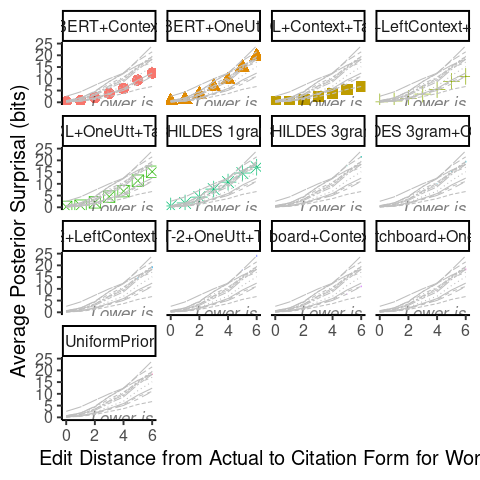

time: 968 ms (started: 2023-01-24 12:31:33 -08:00)


In [252]:
%%R
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)


surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model, linetype=likelihood_type)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=surprisal_for_gray, aes(x=edit_distance,y=mean_posterior_surprisal, linetype = line_model),colour='gray', alpha=1)+
theme(legend.position='none')
print(p1)

#### Levenshtein Distance Plots

In [253]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior" & likelihood_type == 'Levenshtein Distance')[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance_lev = merge(subset(surprisal_by_edit_distance, likelihood_type == 'Levenshtein Distance'), unigram_prior)
surprisal_by_edit_distance_lev$multiplier = 2^( surprisal_by_edit_distance_lev$unigram_prior_prob -
    surprisal_by_edit_distance_lev$mean_posterior_surprisal)

head(surprisal_by_edit_distance_lev, n=10)


   edit_distance                  model      likelihood_type
1              0           BERT+Context Levenshtein Distance
2              0            BERT+OneUtt Levenshtein Distance
3              0       CDL+Context+Tags Levenshtein Distance
4              0   CDL+LeftContext+Tags Levenshtein Distance
5              0        CDL+OneUtt+Tags Levenshtein Distance
6              0          CHILDES 1gram Levenshtein Distance
7              0          CHILDES 3gram Levenshtein Distance
8              0   CHILDES 3gram+OneUtt Levenshtein Distance
9              0 GPT-2+LeftContext+Tags Levenshtein Distance
10             0      GPT-2+OneUtt+Tags Levenshtein Distance
   mean_posterior_surprisal mean_posterior_surprisal_sem      high       low
1                 0.3658364                  0.008981457 0.3748178 0.3568549
2                 0.5303559                  0.010011257 0.5403672 0.5203447
3                 0.2127561                  0.005911217 0.2186673 0.2068449
4                 0.2

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [254]:
%%R

# Added: no subsetting for the odds uniform prior

p2= ggplot(subset(surprisal_by_edit_distance_lev, edit_distance <= 6 & model %in% overview_set 
& likelihood_type =='Levenshtein Distance' & model != 'UniformPrior')) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=512, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2'
) + scale_shape_manual(values = 1:8) + scale_color_manual(values = 1:8)    
print(p2)

R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



Error in `f()`:
! Insufficient values in manual scale. 12 needed but only 8 provided.
Run `rlang::last_error()` to see where the error occurred.


R[write to console]: Warning messages:

R[write to console]: 1: The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 13. Consider
specifying shapes manually if you must have them. 

R[write to console]: 2: Removed 84 rows containing missing values (geom_point). 

R[write to console]: 3: Ignoring unknown aesthetics: shape 

R[write to console]: 4: Ignoring unknown aesthetics: shape 

R[write to console]: 5: The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 13. Consider
specifying shapes manually if you must have them. 

R[write to console]: 6: Removed 49 rows containing missing values (geom_point). 

R[write to console]: 7: Ignoring unknown aesthetics: shape 




Error in f(...) :
time: 143 ms (started: 2023-01-24 12:31:34 -08:00)


#### WFST Plots

In [541]:
%%R
# make sure it uses the same colors
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)
surprisal_by_edit_distance_for_plot$model_shortname= gsub('\\+Tags','',surprisal_by_edit_distance_for_plot$model)
surprisal_by_edit_distance_for_plot$model_shortname = factor(surprisal_by_edit_distance_for_plot$model_shortname, levels = models_for_13_plots)

time: 11 ms (started: 2023-02-01 11:18:13 -08:00)


In [542]:
%%R
models_for_13_plots

 [1] "CDL+Context"          "CDL+LeftContext"      "BERT+Context"        
 [4] "Switchboard+Context"  "CDL+OneUtt"           "Switchboard+OneUtt"  
 [7] "GPT-2+LeftContext"    "BERT+OneUtt"          "CHILDES 3gram+OneUtt"
[10] "GPT-2+OneUtt"         "CHILDES 1gram"        "CHILDES 3gram"       
[13] "UniformPrior"        
time: 33.2 ms (started: 2023-02-01 11:18:16 -08:00)


In [545]:
%%R
unique(as.character(surprisal_by_edit_distance_for_plot$model_shortname))

 [1] "BERT+Context"         "BERT+OneUtt"          "CDL+Context"         
 [4] "CDL+LeftContext"      "CDL+OneUtt"           "CHILDES 1gram"       
 [7] "CHILDES 3gram"        "CHILDES 3gram+OneUtt" "GPT-2+LeftContext"   
[10] "GPT-2+OneUtt"         "Switchboard+Context"  "Switchboard+OneUtt"  
[13] "UniformPrior"        
time: 32.8 ms (started: 2023-02-01 11:18:43 -08:00)


R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.



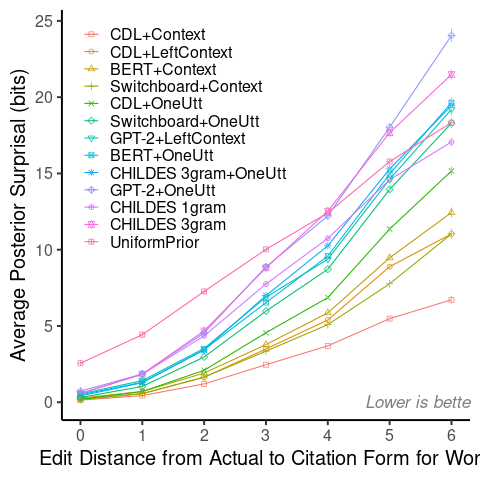

time: 848 ms (started: 2023-02-01 11:21:03 -08:00)


In [549]:
%%R
p1= ggplot(surprisal_by_edit_distance_for_plot)  + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model_shortname, 
shape=model_shortname)) + theme(legend.position=c(.3, .7), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6)
) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model_shortname, shape=model_shortname), size=2) + scale_shape_manual(values=1:nlevels(surprisal_by_edit_distance_for_plot$model)) + scale_color_manual(
        values=1:nlevels(surprisal_by_edit_distance_for_plot$model_shortname)) + scale_color_manual(
        values=colors_for_13_plots) + scale_shape_manual(values = shapes_for_13_plots) + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high), color="gray", width=0)


ggsave('../../output/figures/surpsisal_by_edit_distance_wfst.pdf', height=6, width=8)    
print(p1)

### Proportion Agreeing with Annotator Per Age

In [260]:
%%R
names(successes_across_time)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "model_remapped"       
time: 22.1 ms (started: 2023-01-24 12:31:35 -08:00)


In [261]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model + age + likelihood_type, successes_across_time, function(x){mean(x == 0)})

time: 3.07 s (started: 2023-01-24 12:31:35 -08:00)


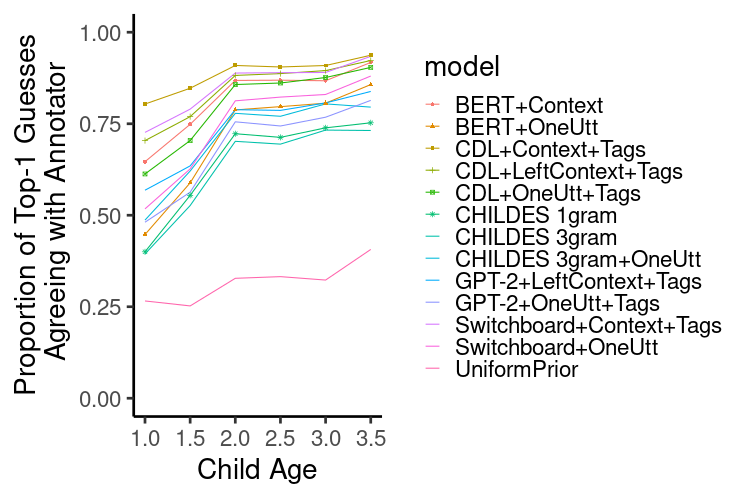

time: 381 ms (started: 2023-01-24 12:31:38 -08:00)


In [262]:
%%R -w 750 -h 500
ggplot(filter_model_subset(subset(proportion_retrieved, likelihood_type == 'WFST'), overview_set)) + geom_line(aes(x=age, y=posterior_rank, color=model)
) + geom_point(aes(x=age, y=posterior_rank, color=model, shape=model)) + coord_cartesian(ylim=c(0,1)) + xlab('Child Age') + ylab(
    'Proportion of Top-1 Guesses\n Agreeing with Annotator') + theme_classic(base_size=28) + theme(legend.background = element_blank())




### Posterior by Edit Distance by Likelihood 

In [263]:
from src.utils import load_splits
all_tokens_phono = load_splits.load_phono()

time: 8.31 s (started: 2023-01-24 12:31:39 -08:00)


In [264]:
all_tokens_phono.columns

Index(['token', 'utterance_id', 'gloss', 'transcript_id', 'utterance_order',
       'target_child_name', 'speaker_code', 'type', 'punct',
       'speaker_code_simple', 'gloss_with_punct', 'token_id', 'seq_utt_id',
       'actual_phonology', 'model_phonology', 'target_child_age',
       'bert_token_id', 'model_phonology_clean', 'actual_phonology_clean',
       'model_phonology_no_dia', 'actual_phonology_no_dia', 'cv_raw_actual',
       'cv_collapsed_actual', 'num_vowels_actual', 'cv_raw_model',
       'cv_collapsed_model', 'num_vowels_model', 'num_vowels', 'in_vocab',
       'success_token', 'yyy_token', 'partition', 'phase', 'year',
       'phase_child_sample', 'phase_child_finetune',
       'phase_child_sample_n=2_type=success_name=Alex',
       'phase_child_sample_n=2_type=success_name=Ethan',
       'phase_child_sample_n=2_type=success_name=Lily',
       'phase_child_sample_n=2_type=success_name=Naima',
       'phase_child_sample_n=2_type=success_name=Violet',
       'phase_child_sa

time: 3.36 ms (started: 2023-01-24 12:31:47 -08:00)


In [265]:
all_tokens_phono['citation_len'] = [len(x) for x in all_tokens_phono.model_phonology_no_dia]
all_tokens_phono['child_len'] = [len(x) for x in all_tokens_phono.actual_phonology_no_dia]
all_tokens_phono['phono_change'] = all_tokens_phono['child_len'] - all_tokens_phono['citation_len']
ipa_tokens = all_tokens_phono.dropna(subset=['actual_phonology_no_dia'])[['bert_token_id','phono_change']]
%R -i ipa_tokens

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


time: 26.5 s (started: 2023-01-24 12:31:47 -08:00)


In [266]:
%%R
ed_with_phono_change = merge(ed, ipa_tokens)

time: 2min 20s (started: 2023-01-24 12:32:14 -08:00)


In [267]:
%%R
names(ed_with_phono_change)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "likelihood_type"      
[13] "prior_rank"            "posterior_rank"        "model_remapped"       
[16] "wfst_distance"         "edit_distance"         "phono_change"         
time: 37.9 ms (started: 2023-01-24 12:34:34 -08:00)


In [268]:
%%R

#need the length of the adult string vs. the child string 

prob_by_edit_distance_likelihood = aggregate(posterior_probability ~ likelihood_type + phono_change + model, ed_with_phono_change, mean)

prob_by_edit_distance_likelihood_sem = aggregate(posterior_probability ~ likelihood_type + phono_change + model, ed_with_phono_change, sem)
names(prob_by_edit_distance_likelihood_sem) = c('likelihood_type', 'phono_change', 'model', 'sem')

prob_by_edit_distance_likelihood = merge(prob_by_edit_distance_likelihood, prob_by_edit_distance_likelihood_sem)
prob_by_edit_distance_likelihood$high = prob_by_edit_distance_likelihood$posterior_probability + prob_by_edit_distance_likelihood$sem
prob_by_edit_distance_likelihood$low = prob_by_edit_distance_likelihood$posterior_probability - prob_by_edit_distance_likelihood$sem


time: 12.3 s (started: 2023-01-24 12:34:34 -08:00)


In [269]:
%%R
prob_by_edit_distance_likelihood$likelihood_type[prob_by_edit_distance_likelihood$likelihood_type ==
    'Levenshtein Distance'] = 'Edit Distance'

time: 6.2 ms (started: 2023-01-24 12:34:46 -08:00)


In [270]:
%%R
prob_by_edit_distance_likelihood$likelihood_type = factor(prob_by_edit_distance_likelihood$likelihood_type, 
levels = c('WFST', 'Edit Distance'))

time: 18.4 ms (started: 2023-01-24 12:34:46 -08:00)


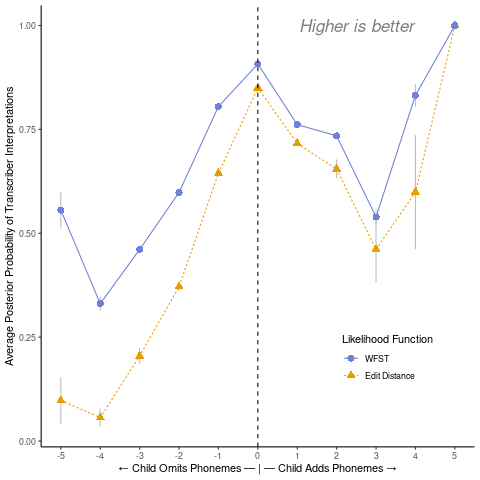

time: 655 ms (started: 2023-01-24 12:34:46 -08:00)


In [271]:
%%R
p1 = ggplot(subset(prob_by_edit_distance_likelihood, model == "CDL+Context+Tags")) + geom_errorbar(
aes(x=phono_change, ymin = low, ymax=high), color='gray', width=0) + geom_line(aes(x=phono_change, y=posterior_probability,
    color = likelihood_type, linetype = likelihood_type )) + geom_point(aes(x=phono_change, y=posterior_probability,
    color = likelihood_type, shape=likelihood_type), size=3) + theme_classic() + ylab('Average Posterior Probability of Transcriber Interpretations') + xlab (
    '← Child Omits Phonemes — | — Child Adds Phonemes →') + geom_vline(xintercept=0, linetype='dashed'
) + scale_x_continuous(breaks=c(-5:5), labels = c(-5:5))  + scale_shape_discrete(name = "Likelihood Function") + scale_linetype_discrete(name = "Likelihood Function") + theme(legend.position = c(.8, .2)
) + annotate("text", label="Higher is better", 
    x=2.5, y=1, alpha=.5, size=6, fontface ="italic")  + scale_color_manual(values=c("#6f80d6", "#E69F00"), name = "Likelihood Function")

ggsave("../../output/figures/likelihood_function_by_change.png", width = 5, height=5)
print(p1)

# Child-Specific Analyses

In [ ]:
# What is the best representation of the variability by child?

In [272]:
all_tokens_phono_short = all_tokens_phono[['bert_token_id','target_child_name']]
%R -i all_tokens_phono_short

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


time: 32.1 s (started: 2023-01-24 12:34:47 -08:00)


In [446]:
%%R
successes_across_time_with_child_label = merge(successes_across_time, all_tokens_phono_short)

time: 37.4 s (started: 2023-01-31 10:22:50 -08:00)


In [447]:
%%R
successes_across_time_with_child_label = subset(successes_across_time_with_child_label, model %in% overview_set)

time: 17.3 s (started: 2023-01-31 10:23:28 -08:00)


In [448]:
%%R
successes_across_time_with_child_label$model = gsub('\\+Tags','', successes_across_time_with_child_label$model)

time: 2.65 s (started: 2023-01-31 10:23:45 -08:00)


In [462]:
%%R
unique(successes_across_time_with_child_label$model)

 [1] "CDL+LeftContext"      "CHILDES 3gram"        "Switchboard+Context" 
 [4] "BERT+Context"         "Switchboard+OneUtt"   "UniformPrior"        
 [7] "CDL+OneUtt"           "CDL+Context"          "GPT-2+OneUtt"        
[10] "BERT+OneUtt"          "GPT-2+LeftContext"    "CHILDES 3gram+OneUtt"
[13] "CHILDES 1gram"       
time: 70.7 ms (started: 2023-01-31 10:26:00 -08:00)


In [463]:
%%R
posterior_entropy_by_child = aggregate(posterior_entropy ~ model + likelihood_type + target_child_name, successes_across_time_with_child_label, mean)

time: 681 ms (started: 2023-01-31 10:26:03 -08:00)


In [464]:
%%R
prior_surprisal_by_child = aggregate(prior_probability ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(-1 *log(x, base=2))})


time: 762 ms (started: 2023-01-31 10:26:05 -08:00)


In [465]:
%%R
posterior_surprisal_by_child = aggregate(posterior_probability ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(-1 *log(x, base=2))})

time: 739 ms (started: 2023-01-31 10:26:06 -08:00)


In [466]:
%%R
posterior_top1 = aggregate(posterior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(posterior_top1)[4] = 'posterior_top1'

time: 895 ms (started: 2023-01-31 10:26:07 -08:00)


In [467]:
%%R
prior_top1 = aggregate(prior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(prior_top1)[4] = 'prior_top1'

time: 693 ms (started: 2023-01-31 10:26:08 -08:00)


In [468]:
%%R
by_child_merged = merge(prior_surprisal_by_child, posterior_surprisal_by_child)
by_child_merged = merge(by_child_merged, posterior_top1)
by_child_merged = merge(by_child_merged, prior_top1)

time: 29.6 ms (started: 2023-01-31 10:26:10 -08:00)


In [469]:
%%R
head(by_child_merged)

         model      likelihood_type target_child_name prior_probability
1 BERT+Context Levenshtein Distance              Alex          5.422285
2 BERT+Context Levenshtein Distance             Ethan          4.710085
3 BERT+Context Levenshtein Distance              Lily          4.034754
4 BERT+Context Levenshtein Distance             Naima          4.729374
5 BERT+Context Levenshtein Distance            Violet          4.411186
6 BERT+Context Levenshtein Distance           William          4.940325
  posterior_probability posterior_top1 prior_top1
1              2.019735      0.7153146  0.3877938
2              2.801825      0.6600922  0.4677254
3              1.035269      0.8351124  0.4837034
4              1.720342      0.7560154  0.4533205
5              1.516671      0.7818268  0.4325603
6              2.187860      0.7156601  0.4183146
time: 77.7 ms (started: 2023-01-31 10:26:11 -08:00)


/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [470]:
%%R
avg_model_posterior_performance = aggregate(posterior_top1 ~ model, by_child_merged, mean)
avg_model_posterior_performance = avg_model_posterior_performance[order(avg_model_posterior_performance$posterior_top1),]
avg_model_posterior_performance

                  model posterior_top1
13         UniformPrior      0.3019341
6         CHILDES 1gram      0.5707626
7         CHILDES 3gram      0.5910354
10         GPT-2+OneUtt      0.6340655
8  CHILDES 3gram+OneUtt      0.6794479
2           BERT+OneUtt      0.6861160
9     GPT-2+LeftContext      0.6862858
12   Switchboard+OneUtt      0.7051559
5            CDL+OneUtt      0.7640569
1          BERT+Context      0.7864811
4       CDL+LeftContext      0.8043996
11  Switchboard+Context      0.8102146
3           CDL+Context      0.8472984
time: 60.4 ms (started: 2023-01-31 10:26:24 -08:00)


/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [471]:
%%R
by_child_merged$model = factor(by_child_merged$model, levels=avg_model_posterior_performance$model)

time: 10.9 ms (started: 2023-01-31 10:26:41 -08:00)


In [460]:
# order the models by the average model performance

time: 5.22 ms (started: 2023-01-31 10:24:48 -08:00)


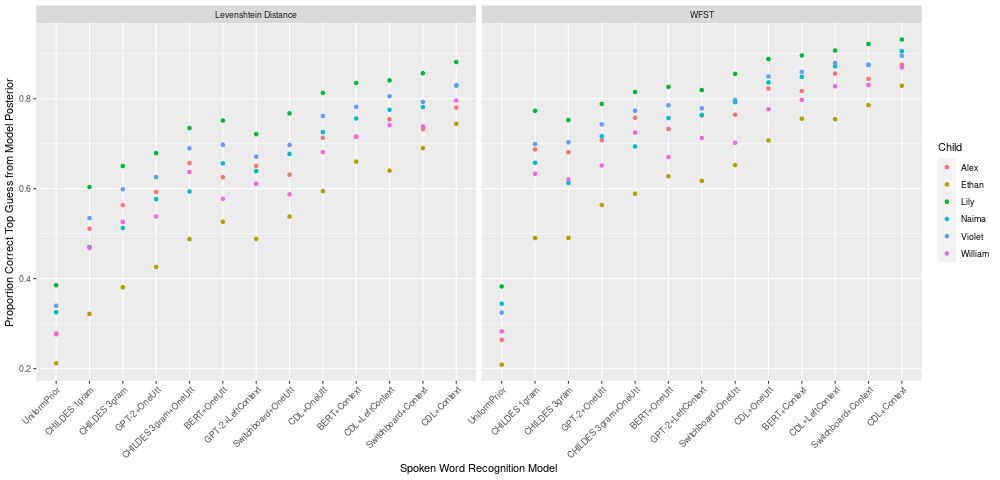

time: 649 ms (started: 2023-01-31 10:58:47 -08:00)


In [479]:
%%R -w 1000
p1 = ggplot(by_child_merged) + geom_point(aes(x=model, y=posterior_top1,
color=target_child_name)) + facet_wrap(~ likelihood_type
) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)
) + ylab('Proportion Correct Top Guess from Model Posterior') +  labs(color='Child') + xlab('Spoken Word Recognition Model')
ggsave('../../output/figures/posterior_by_child.pdf', width = 10, height=5)
p1

In [473]:
%%R
avg_model_prior_performance = aggregate(prior_top1 ~ model, by_child_merged, mean)
avg_model_prior_performance = avg_model_prior_performance[order(avg_model_prior_performance$prior_top1),]

time: 14.6 ms (started: 2023-01-31 10:27:12 -08:00)


In [474]:
%%R
avg_model_prior_performance

                  model prior_top1
1          UniformPrior 0.00000000
2         CHILDES 1gram 0.02981087
3         CHILDES 3gram 0.13420266
4          GPT-2+OneUtt 0.16662793
6           BERT+OneUtt 0.23621720
8    Switchboard+OneUtt 0.26555184
5  CHILDES 3gram+OneUtt 0.29009423
7     GPT-2+LeftContext 0.29516002
9            CDL+OneUtt 0.35355947
10         BERT+Context 0.44056967
11      CDL+LeftContext 0.45202449
12  Switchboard+Context 0.48853230
13          CDL+Context 0.55391823
time: 61.2 ms (started: 2023-01-31 10:27:16 -08:00)


/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [476]:
%%R
by_child_merged$prior_model = factor(by_child_merged$model, levels=avg_model_prior_performance$model)

time: 10.8 ms (started: 2023-01-31 10:27:35 -08:00)


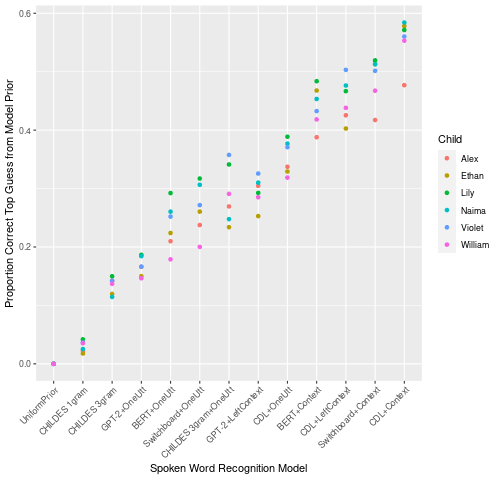

time: 742 ms (started: 2023-01-31 10:59:14 -08:00)


In [481]:
%%R -w 500
p2 = ggplot(subset(by_child_merged, likelihood_type == "WFST")) + geom_point(aes(x=prior_model, y=prior_top1,
color=target_child_name)) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)
) + ylab('Proportion Correct Top Guess from Model Prior') +  labs(color='Child') + xlab('Spoken Word Recognition Model')
ggsave('../../output/figures/prior_by_child.pdf', width = 5, height=5)
p2